<a href="https://colab.research.google.com/github/lapidesd/wetted_channels_from_space/blob/main/Colab_notebooks/wetted_channel_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import math
import matplotlib.ticker as ticker
import matplotlib
%config InlineBackend.figure_format='retina'

/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load data


In [2]:
site = 'Cienega'

In [26]:
site = 'Cienega'
import glob
# load imagery data
if site=='Ramsey':
    df = pd.read_csv('../data/'+site+'/processed_assumptions/processed_with_dates_and_assumptions.csv')
elif site=='Cienega':
    df =  glob.glob('../data/'+site+'/processed_assumptions/*.csv')
    df = [pd.read_csv(s) for s in df]
    df = pd.concat(df)
df['date'] = pd.to_datetime(df.date)
df['date'] = df.date.dt.date
df = df.groupby(['x','y','date']).first().reset_index()

#load hydro data
hydro = pd.read_csv('../data/'+site+'/'+site+'HydroData.csv')
if site=='Ramsey':
    hydro['Unnamed: 0'] = pd.to_datetime(hydro['Unnamed: 0'])
    hydro.set_index('Unnamed: 0',inplace=True)
elif site=='Cienega':
    hydro['datetime'] = pd.to_datetime(hydro['datetime'])
    hydro.set_index('datetime',inplace=True)
    
# load imagery metadata
metad = pd.read_csv('../data/'+site+'/'+site+'_imagery_metadata.csv')
metad['acquired'] = pd.to_datetime(metad.acquired)
metad['doy'] = metad.acquired.dt.dayofyear
metad['time'] = metad.acquired.dt.hour
metad['date'] = metad.acquired.dt.date
metad = metad.groupby('date').first().reset_index()

# load imagery summary data values
imagd = pd.read_csv('../data/'+site+'/'+site+'_imagery_summary_values.csv')
imagd['date'] = pd.to_datetime(imagd['date'],format='%Y%m%d')
imagd['date'] = imagd.date.dt.date
imagd.drop(columns='Unnamed: 0',inplace=True)
imagd = imagd.set_index('date').sort_index().reset_index().groupby('date').first().reset_index()


## Normalize data values

In [27]:
df = df.merge(imagd,on='date')

In [28]:
for band in ['blue','green','red','NIR']:
    if band=='NIR':
        band1 = 'nir'
    else:
        band1 = band
#     df[band] = (df[band]-df[band1+'1'].median())/(df[band1+'99'].median()-df[band1+'1'].median())
    df[band] = (df[band]-df[band1+'1'])/(df[band1+'99']-df[band1+'1'])

# Random Forest

## make estimator and predictor dataframes, run model

In [29]:
df = df.merge(metad,on='date')
df['month'] = df.acquired.dt.month
df['season'] = np.where(df.month.isin([11,12,1]),1,0)
df['season'] = np.where(df.month.isin([2,3,4,]),1,df.season)
df['season'] = np.where(df.month.isin([5,6,7]),1,df.season)
df['season'] = np.where(df.month.isin([8,9,10]),1,df.season)

In [30]:
df.to_csv('cienega_data.csv')

In [31]:
df1 = df#[(df.assumption!='assumed perennial')]#|(pd.to_datetime(df.date).dt.year>2022)]
# df1 = df[df.assumption!='assumed perennial']
features = ['blue', 'green', 'red', 'NIR', 'NDWI',#'month',
#            'satellite_azimuth','time','sun_azimuth','sun_elevation','view_angle'
           ]
X = df1[features]
# X = X[X.assumption!='assumed perennial']
# X.drop(columns='assumption',inplace=True)
X = X.fillna(X.median())
df1['wet'] = np.where(df1.wetdry=='wet',1,0)
Y = df1['wet']
print('Depth of binary tree on num samples is %.0f'%np.log2(np.shape(X)[0]))

Depth of binary tree on num samples is 17


# Hyperparameter search on max_depth
---

Default parameters (maxdepth = None) are likely the best option as hyperparameter search finds optimal $\mathrm{maxdepth}=30 \gg log_2(N)$, where $N$ is the number of samples. For simplicity, we stick with default hyperparameters.

In [307]:
from sklearn.model_selection import GridSearchCV,\
RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

param_grid = {
    'max_depth': [3, 6, 9, 15, 18, 20, ]#30, 50, 75, 100, 125, 150],
}

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,
                                                random_state=42)

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid, n_jobs=-1)
grid_search.fit(Xtrain, ytrain)
print(grid_search.best_estimator_)

/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version 

RandomForestClassifier(max_depth=20)


# get basic fit metrics on train/test split, train model

In [32]:
mdepth = 20

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(df[df.wetdry=='dry'][features], df[df.wetdry=='dry'].wet,
#                                                 random_state=42,train_size = .99)
# df = df[df.assumption!='assumed perennial']
# Xtrain, Xtest, ytrain, ytest = train_test_split(df[df.wetdry=='wet'][features], df[df.wetdry=='wet'].wet,
#                                                 random_state=42,train_size=.1)
# df1 = df[~df.assumption.isin(['assumed perennial','assumed wet'])]
df1['wet'] = np.where(df1.wetdry=='wet',1,0)
Xtrain, Xtest, ytrain, ytest = train_test_split(df1[features], df1.wet,
                                                random_state=42,)

# Xtrain = pd.concat([Xtrain,Xtrain1])
# Xtest = pd.concat([Xtest,Xtest1,Xtrain1])
# ytrain = pd.concat([ytrain,ytrain1])
# ytest = pd.concat([ytest,ytest1,ytrain1])

test_model = RandomForestClassifier(random_state=42)
test_model.fit(Xtrain, ytrain)

## FINAL MODEL TRAINED ON ALL DATA

model = RandomForestClassifier(random_state=42,max_depth=mdepth,)
model.fit(X, Y)
# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
ypred = model.predict(Xtest)

In [34]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m,Xtrain=Xtrain,ytrain=ytrain,Xtest=Xtest,ytest=ytest):
    res = [rmse(m.predict(Xtrain), ytrain), rmse(m.predict(Xtest), ytest),
                m.score(Xtrain, ytrain), m.score(Xtest, ytest)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print('RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set,oobscore(optional)')
    print(res)

print_score(test_model)

RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set,oobscore(optional)
[0.004987422616842001, 0.46758999130664836, 0.9999751256156411, 0.7813596000298485]


In [39]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(
    test_model, X, Y, train_sizes=[round(t) for t in np.linspace(100,len(X)*.75,20)], )

In [49]:
testdf = pd.DataFrame.from_dict({i:[train_scores[j][i] for j in range(len(train_scores))] for i in range(len(train_scores[0]))
                                })
testdf['sizes'] = train_sizes
testdf = testdf.set_index('sizes')

testdf1 = pd.DataFrame.from_dict({i:[valid_scores[j][i] for j in range(len(train_scores))] for i in range(len(train_scores[0]))
                                })
testdf1['sizes'] = train_sizes
testdf1 = testdf1.set_index('sizes')
testdf1

,0,1,2,3,4
sizes,,,,,
100,0.333499,0.666501,0.666687,0.666687,0.666553
6442,0.333499,0.631553,0.661806,0.683944,0.667827
12785,0.451340,0.655992,0.691903,0.694049,0.679270
19127,0.479323,0.650239,0.673714,0.672253,0.665900
25470,0.534451,0.649649,0.663454,0.650955,0.642580
31812,0.591288,0.677570,0.641471,0.633823,0.622182
38155,0.600429,0.662583,0.664542,0.655525,0.642548
44497,0.607238,0.720913,0.683788,0.660687,0.659836
50840,0.611778,0.745414,0.703283,0.659256,0.653804


In [56]:
df[df.assumption=='survey/imagery match'].groupby('date').count()*5/1000

,x,y,wetdry,assumption,blue,green,red,NIR,missing,NDWI,...,satellite_azimuth,satellite_id,sun_azimuth,sun_elevation,view_angle,doy,time,month,season,wet
date,,,,,,,,,,,,,,,,,,,,,
2016-09-22,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,...,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205
2017-03-13,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,...,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205
2017-06-09,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,...,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205
2017-09-21,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,...,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205
2017-12-07,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,...,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205
2018-06-04,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,...,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205
2018-09-07,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,...,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205
2018-12-17,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,...,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205
2019-03-26,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,...,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205,13.205


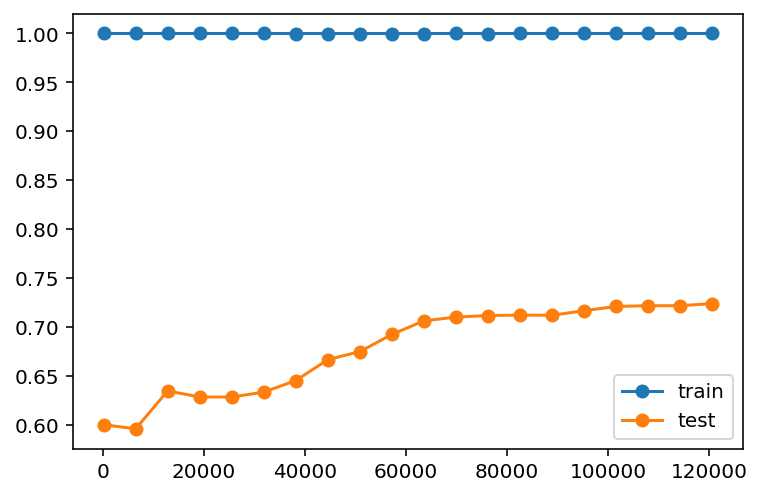

In [52]:
plt.plot(train_sizes,testdf.mean(axis=1),marker='o',label='train')
plt.plot(train_sizes, testdf1.mean(axis=1),marker='o',label='test')
plt.legend()

In [53]:
len(X)

160809

In [17]:
len(df[df.wetdry=='wet'])/len(df)

0.6665049841737714

8167 0.5 0.5
3620 1.5 0.5
5170 0.5 1.5
23246 1.5 1.5


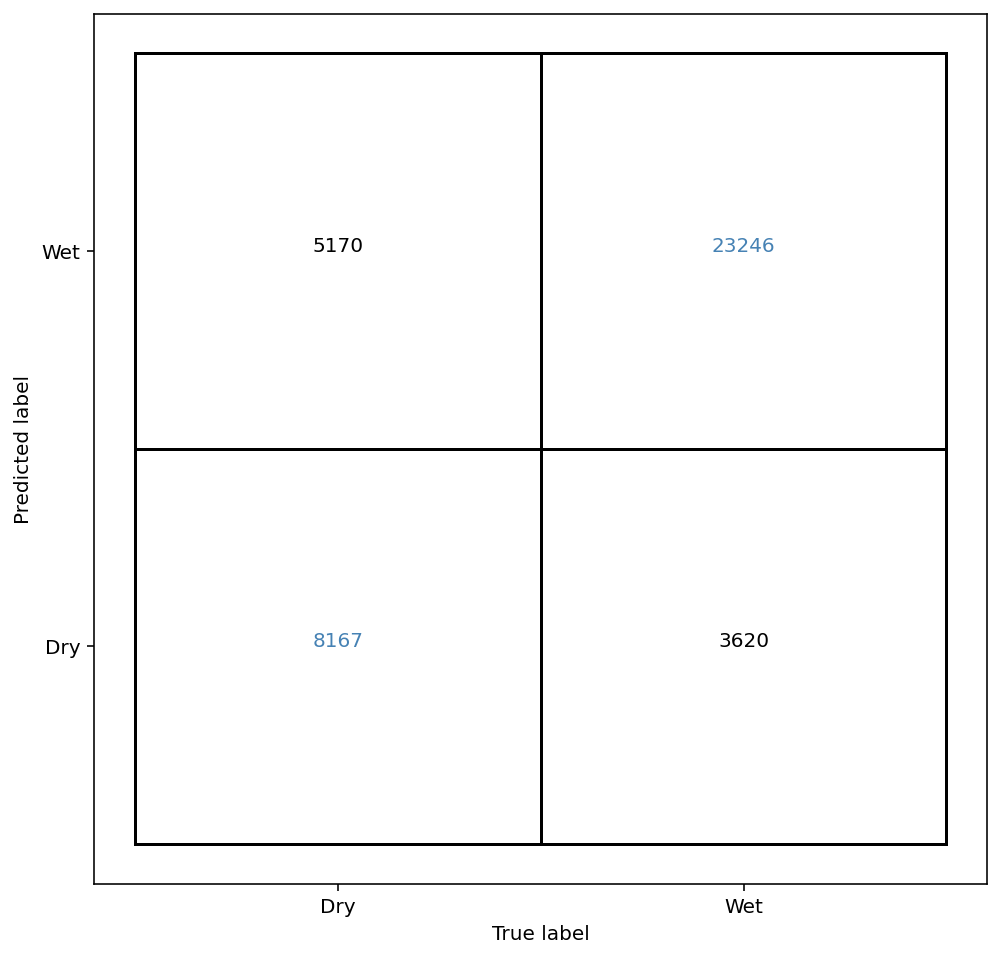

In [12]:
# confusion matrix on test data

from sklearn.metrics import confusion_matrix
# !pip install seaborn
import seaborn as sns

plt.rcParams.update({'font.size': 18})

ytest_predict = test_model.predict(Xtest)
mat = confusion_matrix(ytest, ytest_predict)
f,ax = plt.subplots(1, figsize = (8,8))
# ax.imshow([[1,0],[0,1]],cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['steelblue','k','k','steelblue',]
for i in range(len(mat.T.flatten())):
  t = mat.T.flatten()[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  ax.text(xloc,yloc,t,ha='center',
          c=color,)

ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k')
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')

plt.savefig('correlation_matrix.pdf',format='pdf')

###  Explore accuracy of leave-one-date-out train-test splits


In [284]:
df['date'] = pd.to_datetime(df.date)
df['extrapolatemonth'] = df.date.dt.month
for m in [3,6,9,12]:
    df['extrapolatemonth'] = np.where(abs(df.extrapolatemonth-m)<=1,m,df.extrapolatemonth)
df['extrapolatemonth'] = np.where(df.extrapolatemonth==1,12,df.extrapolatemonth)
df['assumption'] = np.where((df.assumption!='assumed perennial'),
                           [df.assumption.values[i]+' '+str(df.extrapolatemonth.values[i]) for i in range(len(df))],
                           df.assumption)

In [285]:
df['wet'] = np.where(df.wetdry=='dry',0,1)

In [286]:
subset = df
dates = set(subset.date)
subset['date'] = pd.to_datetime(subset.date)
assumptions = df.assumption.unique()

date_accuracy = {}

for date in assumptions:
  print(date)
  mask_test1 = ''
  sub1 = subset.set_index('date').sort_index().reset_index()
  numscenes = 0
  mask_test = (sub1.assumption==date)
  if 'survey/imagery match' in date:
      mask_test1 = (mask_test) | (sub1.assumption=='assumed dry '+date.split()[-1]) | (sub1.assumption=='assumed wet '+date.split()[-1])
  else:
      mask_test1 = mask_test

  Xtrain_date = sub1[~mask_test1][features]
  Xtest_date = sub1[mask_test][features]
  # print(len(Xtest_date))

  ytrain_date = sub1[~mask_test1]['wet']
  ytest_date = sub1[mask_test]['wet']
  date_model = RandomForestClassifier(random_state=42,max_depth=mdepth)
  date_model.fit(Xtrain_date, ytrain_date)
  try:
    date_accuracy.update({date: date_model.score(Xtest_date, ytest_date)})
  except:
    print(date)

survey/imagery match 9 9
survey/imagery match 3 3
survey/imagery match 6 6
survey/imagery match 12 12
assumed wet 9 9
assumed wet 3 3
assumed wet 6 6
assumed wet 12 12
assumed perennial
assumed dry 6 6
assumed dry 3 3
assumed dry 12 12
assumed dry 9 9


In [287]:
date_accuracy.update({'75% of all data as train, 25% as test':test_model.score(Xtest, ytest)})
date_accuracy

{'survey/imagery match 9 9': 0.6021077874542471,
 'survey/imagery match 3 3': 0.5735832386722202,
 'survey/imagery match 6 6': 0.5713744793638773,
 'survey/imagery match 12 12': 0.617190458159788,
 'assumed wet 9 9': 0.9333092354961142,
 'assumed wet 3 3': 0.7266196801301166,
 'assumed wet 6 6': 0.8784033835580227,
 'assumed wet 12 12': 0.6699266503667481,
 'assumed perennial': 0.6828695685640611,
 'assumed dry 6 6': 0.48318681318681317,
 'assumed dry 3 3': 0.310475845847657,
 'assumed dry 12 12': 0.37493999039846376,
 'assumed dry 9 9': 0.27445183542744517,
 '75% of all data as train, 25% as test': 0.7813596000298485}

In [288]:
df.assumption.unique()

array(['survey/imagery match 9 9', 'survey/imagery match 3 3',
       'survey/imagery match 6 6', 'survey/imagery match 12 12',
       'assumed wet 9 9', 'assumed wet 3 3', 'assumed wet 6 6',
       'assumed wet 12 12', 'assumed perennial', 'assumed dry 6 6',
       'assumed dry 3 3', 'assumed dry 12 12', 'assumed dry 9 9'],
      dtype=object)

In [289]:
df[df.wet==1].groupby('assumption').wet.count()
assumptions = df.assumption.unique()
for assumption in assumptions:
    print(assumption,len(df[df.assumption==assumption].date.unique()))
len(df.date.unique())

survey/imagery match 9 9 6
survey/imagery match 3 3 6
survey/imagery match 6 6 7
survey/imagery match 12 12 6
assumed wet 9 9 3
assumed wet 3 3 5
assumed wet 6 6 5
assumed wet 12 12 2
assumed perennial 875
assumed dry 6 6 5
assumed dry 3 3 4
assumed dry 12 12 3
assumed dry 9 9 2


900

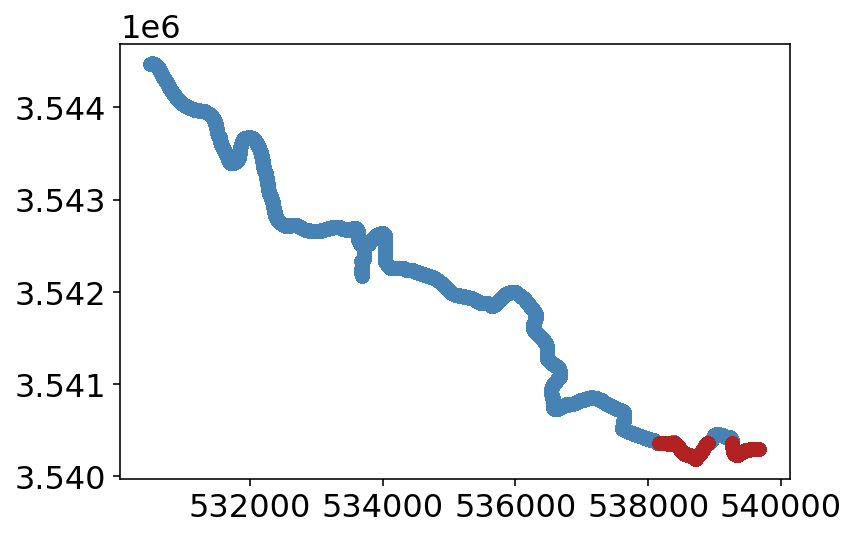

In [290]:
ds = df[df.y>splitval]
plt.scatter(ds.x,ds.y,c='steelblue')
ds = df[df.y<splitval]
plt.scatter(ds.x,ds.y,c='firebrick')

In [291]:
# do comparison from leaving out a single reach

splitval = 3540360
mask_test1 = ''
sub1 = subset.set_index('date').sort_index().reset_index()
numscenes = 0
mask_test = (sub1.y<splitval)
mask_test1 = mask_test

Xtrain_date = sub1[~mask_test1][features]
Xtest_date = sub1[mask_test][features]
# print(len(Xtest_date))

ytrain_date = sub1[~mask_test1]['wet']
ytest_date = sub1[mask_test]['wet']
date_model = RandomForestClassifier(random_state=42,max_depth=mdepth)
date_model.fit(Xtrain_date, ytrain_date)
print(date_model.score(Xtest_date, ytest_date))

0.6129147661210983


# Permutation importance

In [269]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    model, X, Y, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)



/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/danalapides/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core

Elapsed time to compute the importances: 35.730 seconds


8167 0.5 0.5
3620 1.5 0.5
5170 0.5 1.5
23246 1.5 1.5


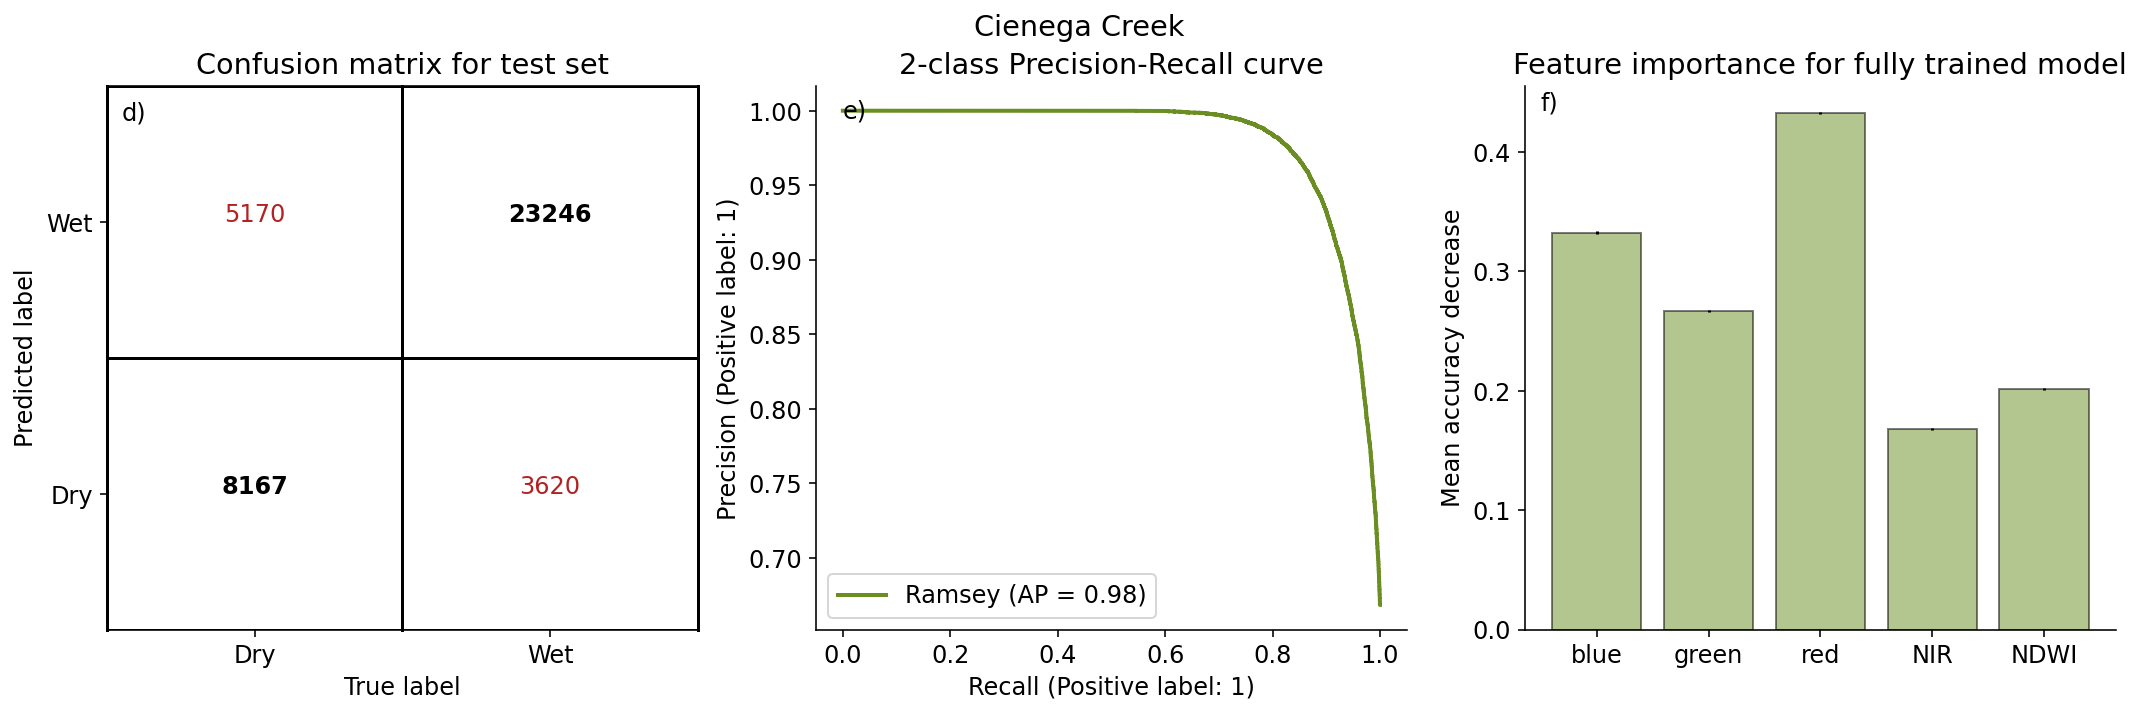

In [270]:
# confusion matrix with feature importance

# Manuscript figure; confusion matrix on test data

plt.rcParams.update({'font.size': 12})

ytest_predict = test_model.predict(Xtest)
mat = confusion_matrix(ytest, ytest_predict)


f,axs = plt.subplots(1, 3, figsize = (18,5))

ax = axs[0]
# sns.heatmap([[1,0],[0,1]], square=True, annot=False,fmt='d',
#             cbar=False,ax=ax, cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['k','firebrick','firebrick','k',]
for i in range(len(mat.T.flatten())):
  t = mat.T.flatten()[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  if color==colors[1]:
        ax.text(xloc,yloc,t,ha='center',
          c=color,)
  else:
    ax.text(xloc,yloc,t,ha='center',
          c=color,weight='demibold')

ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k',clip_on=False)
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')
ax.set_title('Confusion matrix for test set')
ax.text(.05,1.875,'d)',c='k')
ax.set_xlim(0,2)
ax.set_ylim(0,2)

ax = axs[2]

labels = features#['Blue','Green','Red','NIR','NDWI',]#'Area']
ax.bar(labels,forest_importances.values,
       yerr = result.importances_std,
       edgecolor = 'k',facecolor = 'olivedrab',alpha=.5)
ax.set_title("Feature importance for fully trained model")
ax.set_ylabel("Mean accuracy decrease")
ax.text(-.5,0.435,'f)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = axs[1]
from sklearn.metrics import PrecisionRecallDisplay
# fig,ax = plt.subplots(1)
display = PrecisionRecallDisplay.from_estimator(
    model, Xtest, ytest, name="Ramsey", ax=ax, c = 'olivedrab',lw=2
)
_ = display.ax_.set_title("2-class Precision-Recall curve")
ax.spines[['top','right']].set_visible(False)
ax.text(0,.995,'e)')

# fig.tight_layout()

f.suptitle('Cienega Creek')
plt.savefig('confusion_and_importance_cienega.pdf',format='pdf',bbox_inches='tight')

In [254]:
forest_importances#.values, labels, result.importances_std

blue     0.383762
green    0.307909
red      0.482292
NIR      0.193647
NDWI     0.224355
dtype: float64

# make some maps

In [271]:
subset = df1
ypred_all = test_model.predict(df1[features])
subset['prediction'] = ypred_all

In [280]:
df1[df1.assumption.contains('imagery')].date.unique()

<DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]

IndexError: index 6 is out of bounds for axis 0 with size 6

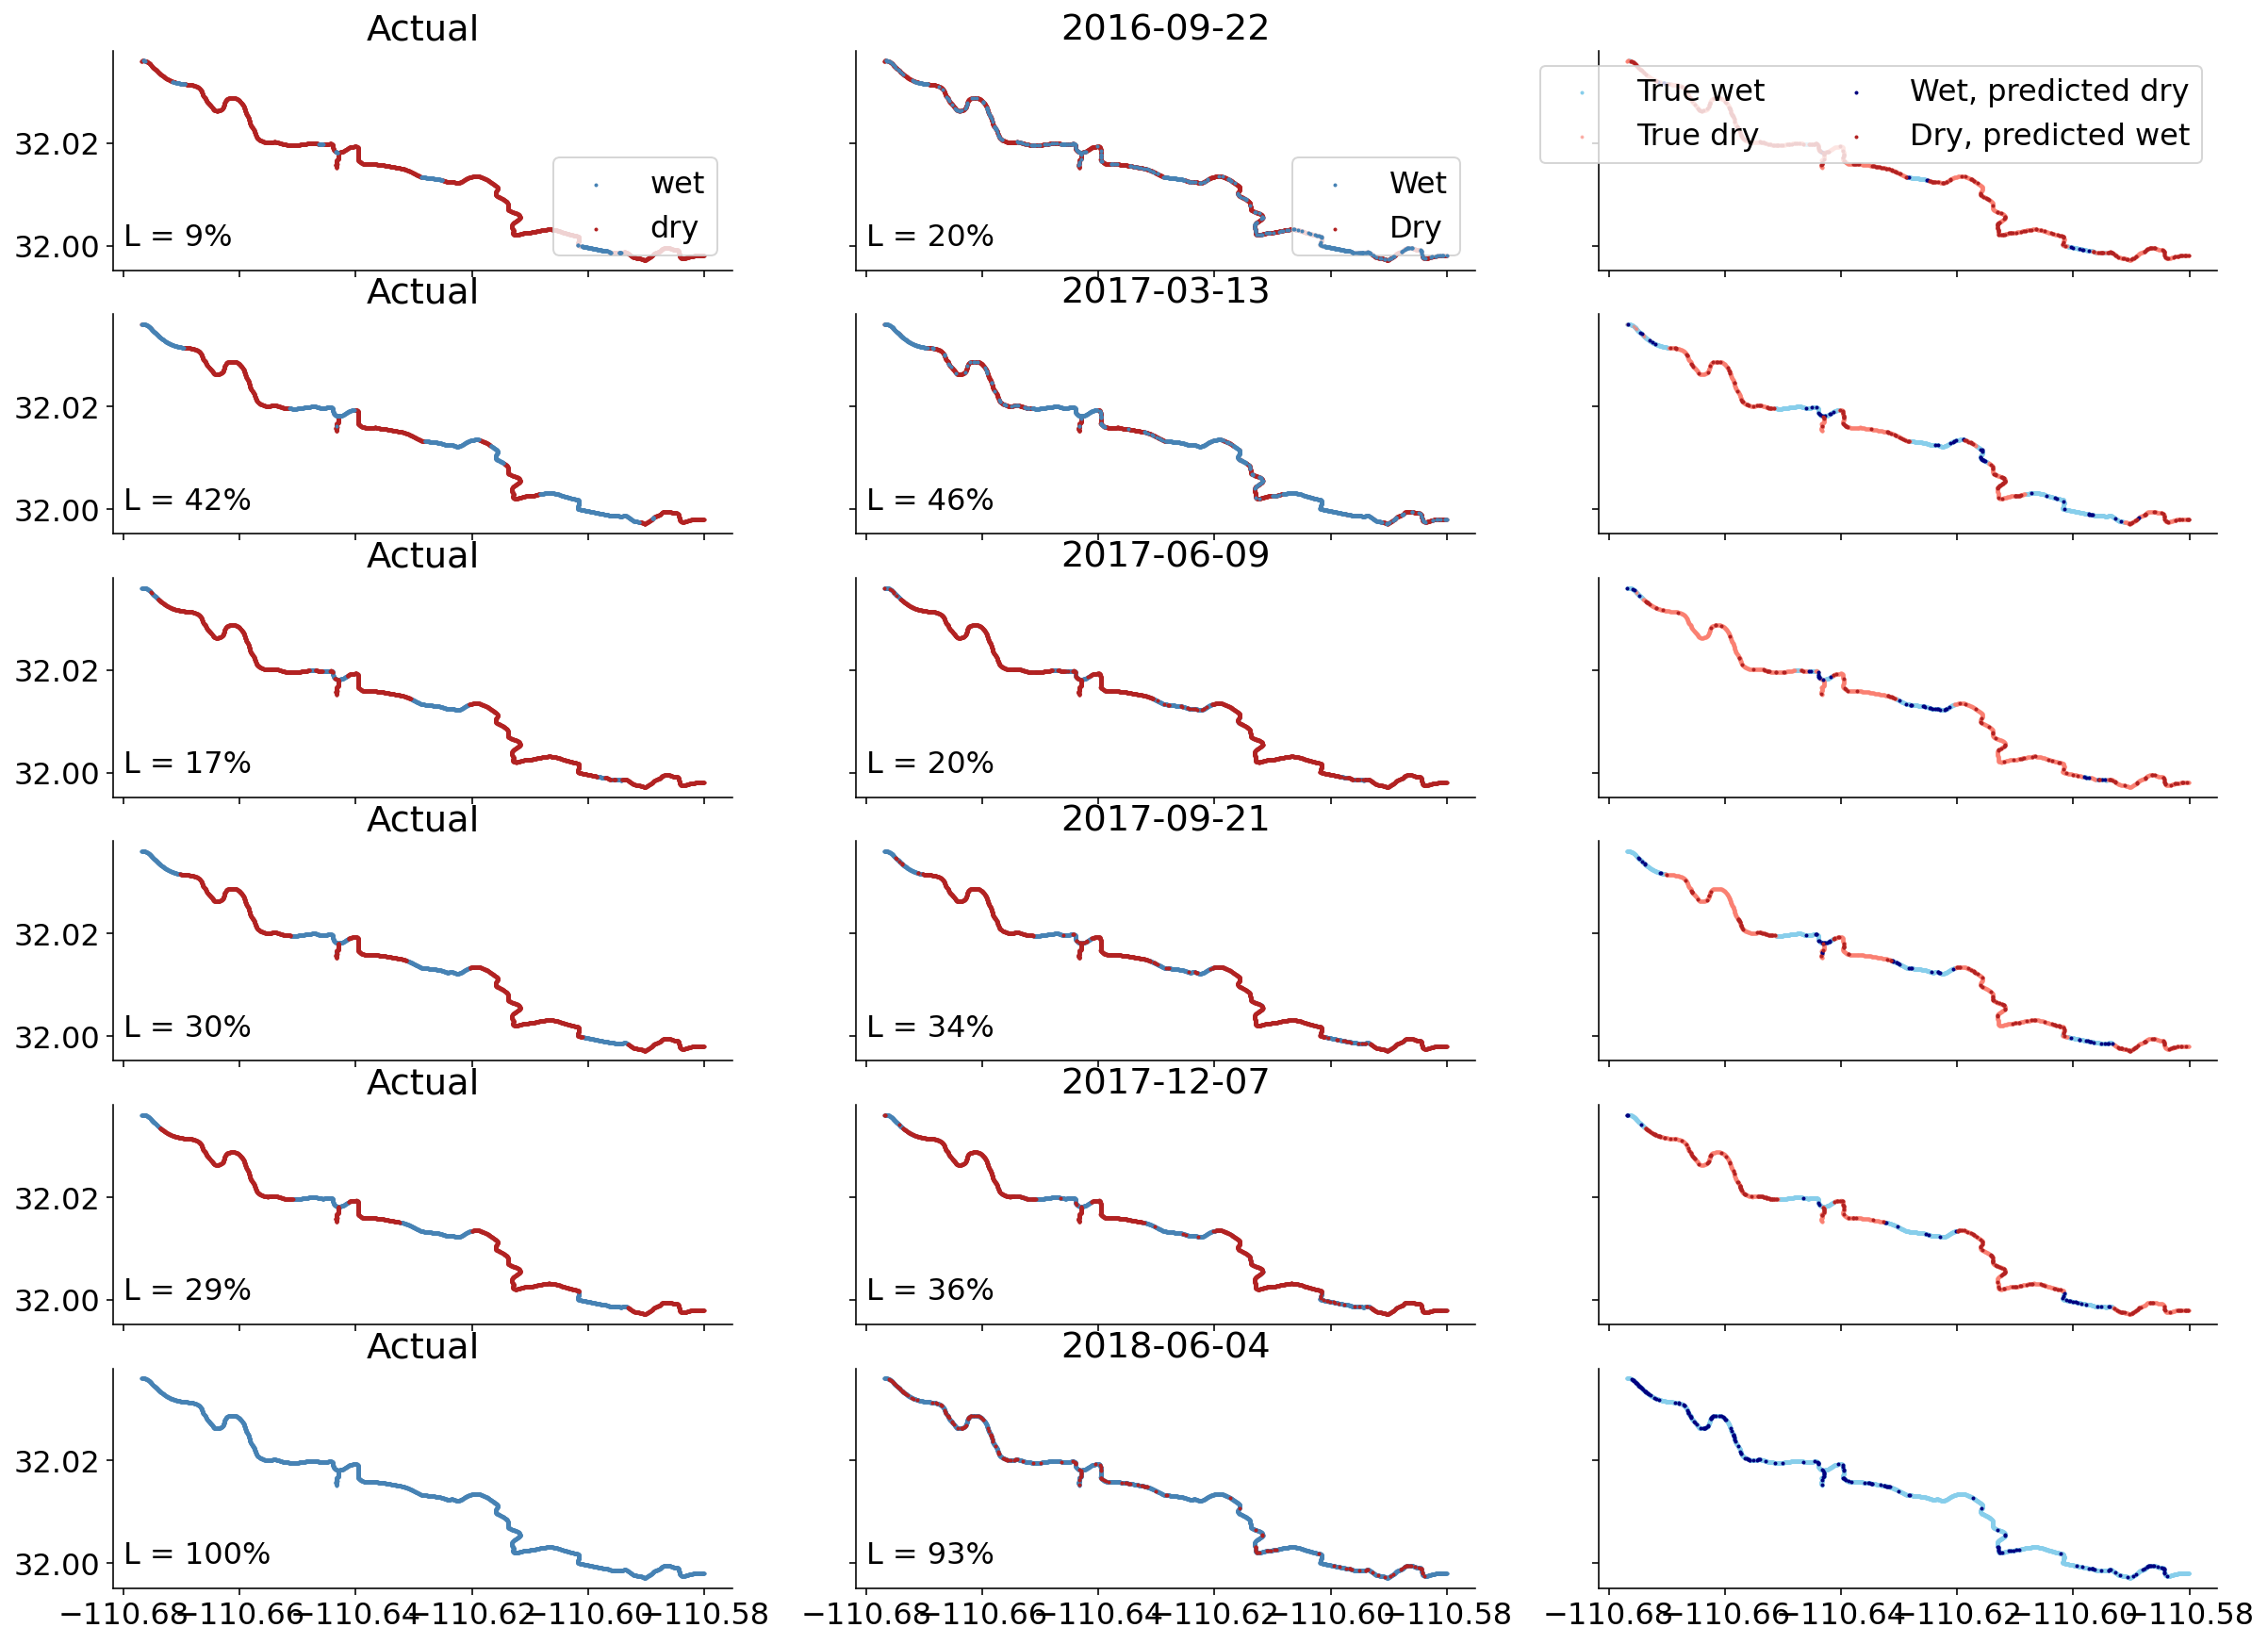

In [283]:
import matplotlib as mpl
import geopandas as gpd

size = 1

plt.rcParams.update({'font.size': 16})

fig,axs = plt.subplots(6,3,figsize = (20,15),
                       sharex=True,
                       sharey=True)


xv,yv = -110.68,32

i=0
for date in df1[df1.assumption.str.contains('imagery')].date.unique():#subset.date.drop_duplicates().values[:4]:
  dfsub = subset[subset.date==date]
  dfsub = dfsub.drop_duplicates()
#   print(dfsub.head())
  dfsub = gpd.GeoDataFrame(
    dfsub, geometry=gpd.points_from_xy(dfsub.x, dfsub.y), crs="EPSG:26912"
)
  dfsub = dfsub.to_crs('EPSG:4326')
  dfsub['x'] = dfsub.geometry.x
  dfsub['y'] = dfsub.geometry.y

  ax = axs[i,0]
  if i>1:
    zorder = -1
    zord1 = 100
  else:
    zorder = 100
    zord1 = -1
  dfsub2 = dfsub[(dfsub.wet==1)]
  pwet = len(dfsub2)/len(dfsub)*100
  ax.scatter(dfsub2.x,dfsub2.y,c='steelblue',
             s=size,label='wet',zorder=zorder)
  dfsub2 = dfsub[(dfsub.wet==0)]
  ax.scatter(dfsub2.x,dfsub2.y,c='firebrick',
             s=size,label='dry',zorder = zord1)
  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

  ax.set_title('Actual')

  ax = axs[i,1]

  dfsub1 = dfsub[(dfsub.prediction==1)]
  pwet = len(dfsub1)/len(dfsub)*100
  ax.scatter(dfsub1.x,dfsub1.y,c='steelblue',
             s=size,label='Wet',
             zorder = zorder)
  dfsub1 = dfsub[(dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,c='firebrick',
             s=size,label='Dry',zorder = zord1)
  ax.set_title(str(date)[:10])
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  ax = axs[i,2]

  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='skyblue',label='True wet',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='salmon',label='True dry',
             s=size, alpha=0.5)
  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='navy',label='Wet, predicted dry',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='firebrick',label='Dry, predicted wet',
             s=size)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  if i==0:
    legend = ax.legend(ncol=2)
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]
#     legend.legendHandles[2]._sizes = [size1]
#     legend.legendHandles[3]._sizes = [size1]
  n = 70

  i+=1



# axs[0,0].text(-123.485,39.585,'Actual',
#               ha = 'center',fontsize = 16)
# axs[0,1].text(-123.485,39.585,'Predicted',
#               ha = 'center',fontsize = 16)
# axs[0,2].text(-123.485,39.585,'Comparison',
#               ha = 'center',fontsize = 16)

# labels = ['a)','b)','c)',
#           'd)','e)','f)',
#           'g)','h)','i)',
#           'j)','k)','l)']

# k=0
# for i in range(4):
#   for j in range(3):
#     axs[i,j].text(-123.517,39.579,labels[k],
#                   fontsize = 16)
#     # print(i,j,k)
#     k+=1

# ax = axs[3,0]
# labels = [item.get_text() for item in ax.get_xticklabels()]
# for ax in [axs[3,0],axs[3,1],axs[3,2]]:
#   ax.set_xticklabels(labels,rotation=90)
#   ax.set_xlabel('Longitude')

# for ax in [axs[0,0],axs[1,0],axs[2,0]]:
#   ax.set_ylabel('Latitude')

# plt.savefig('training_maps.pdf',format='pdf',bbox_inches='tight')

# Make predictions for all dates with PlanetScope data

In [273]:
# read in data
import glob

df_alldates = glob.glob('../data/'+site+'/processed_imagery/*.csv')
df_alldates = [pd.read_csv(s) for s in df_alldates]
df_alldates = pd.concat(df_alldates)
df_alldates = df_alldates.dropna().drop_duplicates()
df_alldates = df_alldates.groupby(['geometry','date']).first().reset_index()
df_alldates['date'] = pd.to_datetime(df_alldates['date'],format='%Y%m%d')
df_alldates['date'] = df_alldates.date.dt.date
df_alldates = df_alldates.merge(metad,on='date')
df_alldates['month'] = pd.to_datetime(df_alldates.date).dt.month
# df_alldates['x'] = [float(df_alldates.geometry.values[i].split('(')[1].split()[0]) for i in range(len(df_alldates))]
# df_alldates['y'] = [float(df_alldates.geometry.values[i].split('(')[1].split()[1][:-1]) for i in range(len(df_alldates))]
# df_alldates = gpd.GeoDataFrame(
#     df_alldates, geometry=gpd.points_from_xy(df_alldates.x,df_alldates.y),crs='EPGS:26912')
# df_alldates = df_alldates.to_crs('EPSG:4326')
df_alldates['season'] = np.where(df_alldates.month.isin([11,12,1]),1,0)
df_alldates['season'] = np.where(df_alldates.month.isin([2,3,4,]),1,df_alldates.season)
df_alldates['season'] = np.where(df_alldates.month.isin([5,6,7]),1,df_alldates.season)
df_alldates['season'] = np.where(df_alldates.month.isin([8,9,10]),1,df_alldates.season)

In [274]:
# normalize bands
imagd['date'] = pd.to_datetime(imagd.date)
df_alldates['date'] = pd.to_datetime(df_alldates.date)
df_alldates = df_alldates.merge(imagd,on='date')

for band in ['blue','green','red','NIR']:
    if band=='NIR':
        band1 = 'nir'
    else:
        band1 = band
#     df[band] = (df[band]-df[band1+'1'].median())/(df[band1+'99'].median()-df[band1+'1'].median())
    df_alldates[band] = (df_alldates[band]-df_alldates[band1+'1'])/(df_alldates[band1+'99']-df_alldates[band1+'1'])

In [275]:
X_alldates = df_alldates[features]
X_alldates.replace([np.inf, -np.inf], np.nan, inplace=True)
X_alldates = X_alldates.fillna(X_alldates.median())

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_15894/2470643163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_alldates.replace([np.inf, -np.inf], np.nan, inplace=True)


In [276]:
ypred_alldates = model.predict(X_alldates)
df_alldates['predict'] = ypred_alldates

In [277]:
df_alldates

,geometry,date,blue,green,red,NIR,missing,NDWI,p,acquired,...,season,blue1,blue99,green1,green99,red1,red99,nir1,nir99,predict
0,POINT (530504.9861314425 3544469.026955865),2016-09-22,0.631644,0.692441,0.676374,0.889954,0,-0.34,0,2016-09-22 17:14:53.866830+00:00,...,1,0.0,1326.0,0.0,1651.0,0.0,2209.0,0.0,2609.0,0
1,POINT (530504.9861314425 3544469.026955865),2016-11-17,0.628959,0.711351,0.747248,0.885906,0,-0.33,0,2016-11-17 17:15:52.741158+00:00,...,1,0.0,1326.0,0.0,1651.0,0.0,2209.0,0.0,2609.0,0
2,POINT (530504.9861314425 3544469.026955865),2017-01-30,0.475867,0.585167,0.641820,0.678973,0,-0.29,0,2017-01-30 17:18:17.727126+00:00,...,1,0.0,1326.0,0.0,1651.0,0.0,2209.0,0.0,2609.0,0
3,POINT (530504.9861314425 3544469.026955865),2017-02-15,0.547006,0.630460,0.655351,0.737148,0,-0.30,0,2017-02-15 17:19:23.382302+00:00,...,1,0.0,1326.0,0.0,1651.0,0.0,2209.0,0.0,2609.0,0
4,POINT (530504.9861314425 3544469.026955865),2017-03-13,0.543906,0.625415,0.672653,0.785657,0,-0.33,0,2017-03-13 17:19:31.488394+00:00,...,1,0.0,1326.0,0.0,1651.0,0.0,2209.0,0.0,2609.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339984,POINT (539670.9382846388 3540292.7487816163),2024-04-07,0.327549,0.466118,0.362911,0.920192,0,-0.51,0,2024-04-07 18:01:33.874425+00:00,...,1,0.0,1326.0,0.0,1651.0,0.0,2209.0,0.0,2609.0,1
2339985,POINT (539670.9382846388 3540292.7487816163),2024-04-10,0.252971,0.379703,0.292992,0.835443,0,-0.55,0,2024-04-10 17:16:33.632780+00:00,...,1,0.0,1326.0,0.0,1651.0,0.0,2209.0,0.0,2609.0,1
2339986,POINT (539670.9382846388 3540292.7487816163),2024-04-11,0.228084,0.318861,0.262159,0.762576,0,-0.58,0,2024-04-11 17:20:04.300638+00:00,...,1,0.0,1326.0,0.0,1651.0,0.0,2209.0,0.0,2609.0,1
2339987,POINT (539670.9382846388 3540292.7487816163),2024-04-13,0.328643,0.514367,0.397465,1.041778,0,-0.52,0,2024-04-13 18:12:41.568768+00:00,...,1,0.0,1326.0,0.0,1651.0,0.0,2209.0,0.0,2609.0,1


Text(0.5, 0.98, 'Cienega')

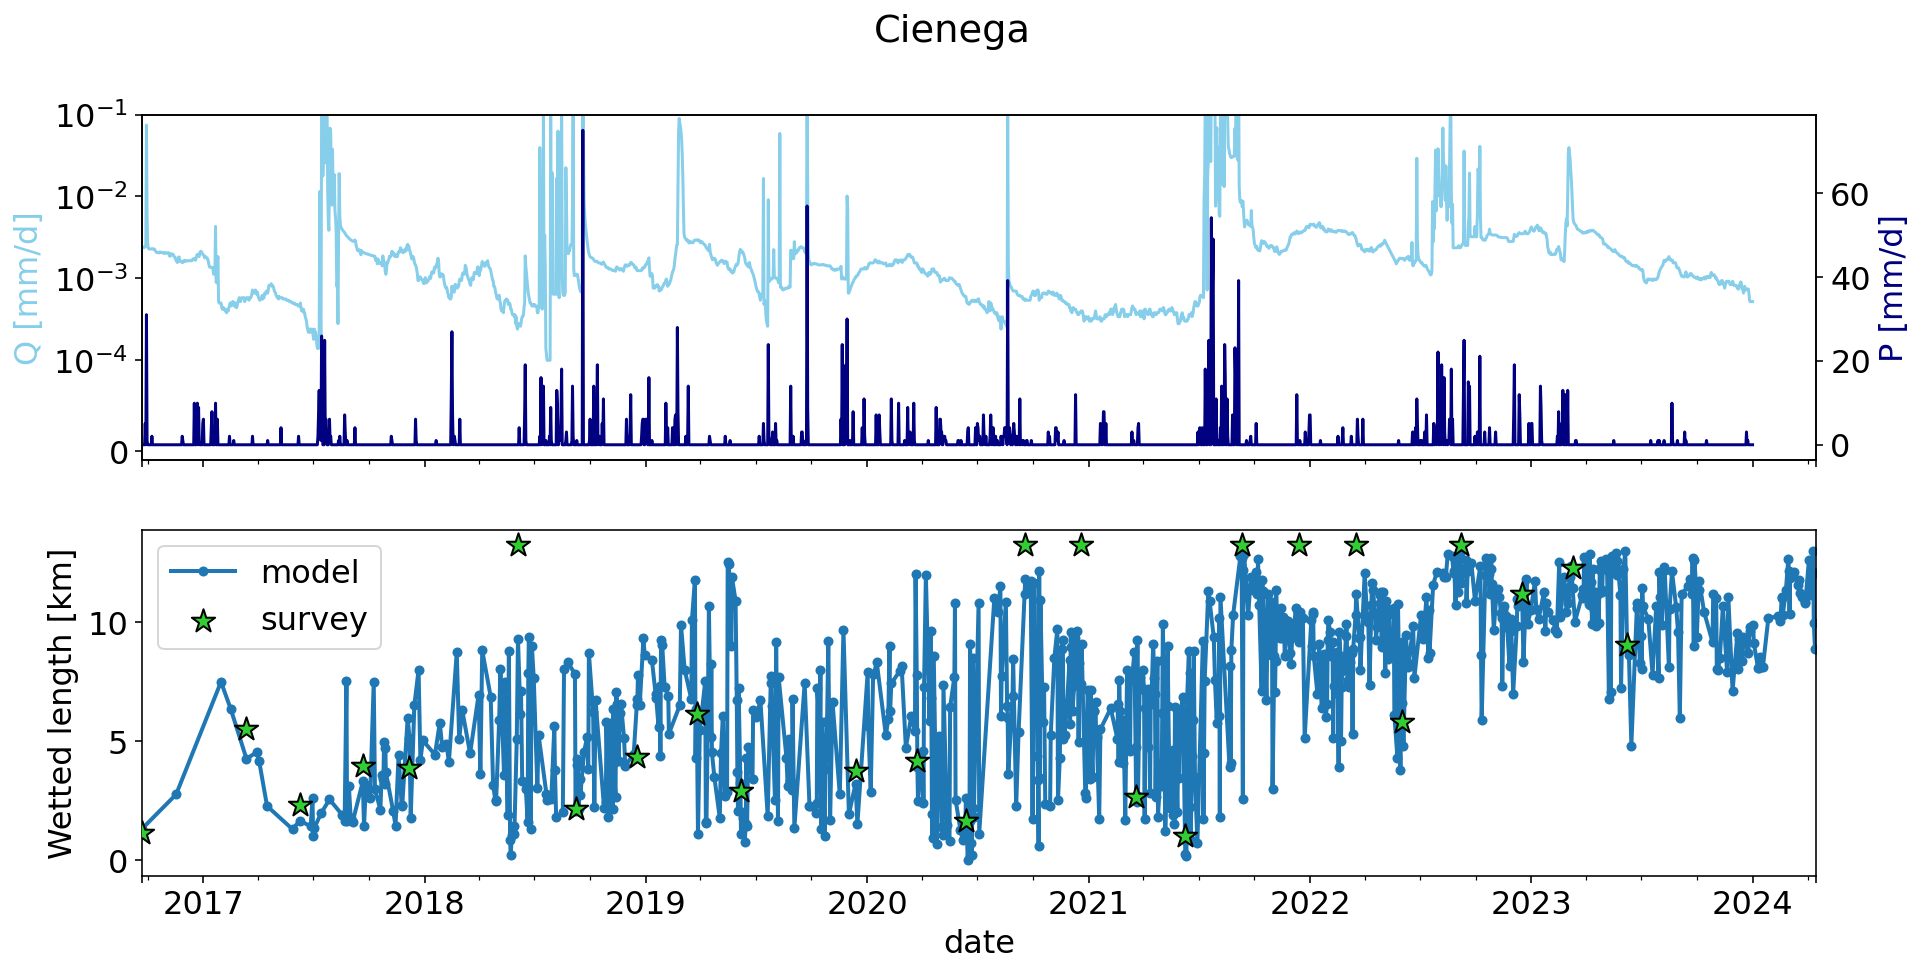

In [278]:
df_alldates['date'] = pd.to_datetime(df_alldates.date,format='%Y%m%d')

fig,axs = plt.subplots(2,figsize = (15,7),sharex=True)
ax = axs[0]
hydro['Q [mm/d]'].plot(ax=ax,c='skyblue')
ax.set_yscale('symlog',linthresh=0.0001)
ax.set_ylim(-.00001,0.1)
ax.set_ylabel('Q [mm/d]',c='skyblue')
axt = ax.twinx()
hydro['P [mm]'].plot(ax=axt,c='navy')
axt.set_ylabel('P [mm/d]',c='navy')
# ax

ax = axs[1]
df_alldates['date'] = pd.to_datetime(df_alldates.date)
datecount = df_alldates.groupby('date').predict.count()
datecount = datecount[datecount>datecount.max()*.99].index.values
dsub = df_alldates[df_alldates.date.isin(datecount)]
(dsub.groupby('date').predict.sum()*5/1000).plot(ax=ax,lw=2,marker='o',markersize = 4,label='model')
ax.set_ylabel('Wetted length [km]')
survey_info = (df[(df.assumption.str.contains('survey/imagery match'))&(df.wet==1)].groupby(['date']).wetdry.count()*5/1000).reset_index()
ax.scatter(survey_info.date.values,survey_info.wetdry.values,
           c='limegreen',marker='*',s=150,label='survey',zorder = 100,
          edgecolor = 'k')
ax.legend()

fig.suptitle(site)

<Axes: xlabel='date'>

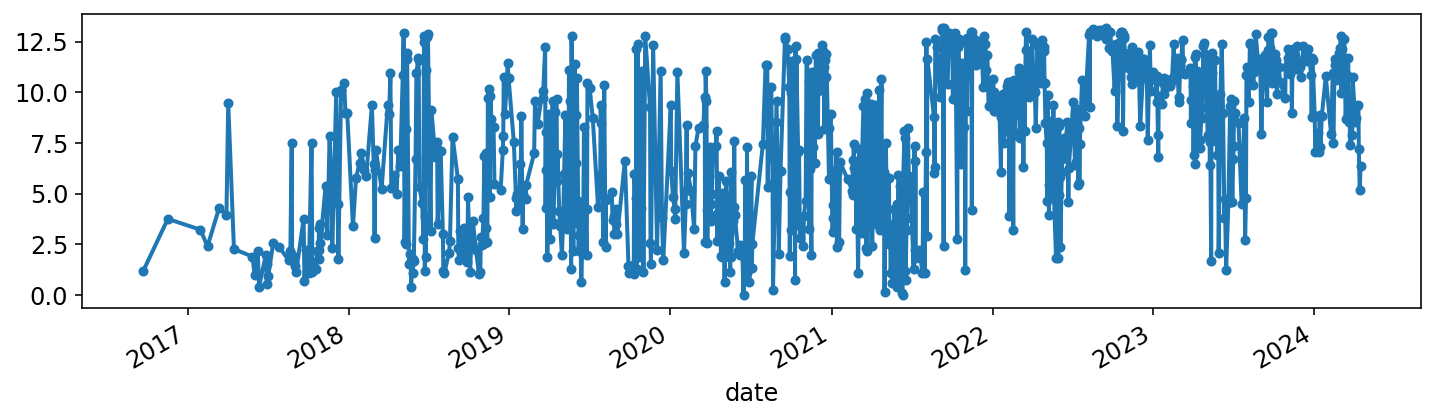

In [258]:
(df_alldates.groupby('date').predict.sum()*5/1000).plot(lw=2,marker='o',
                                                        figsize = (12,3),markersize = 4,label='model')


<Axes: xlabel='date'>

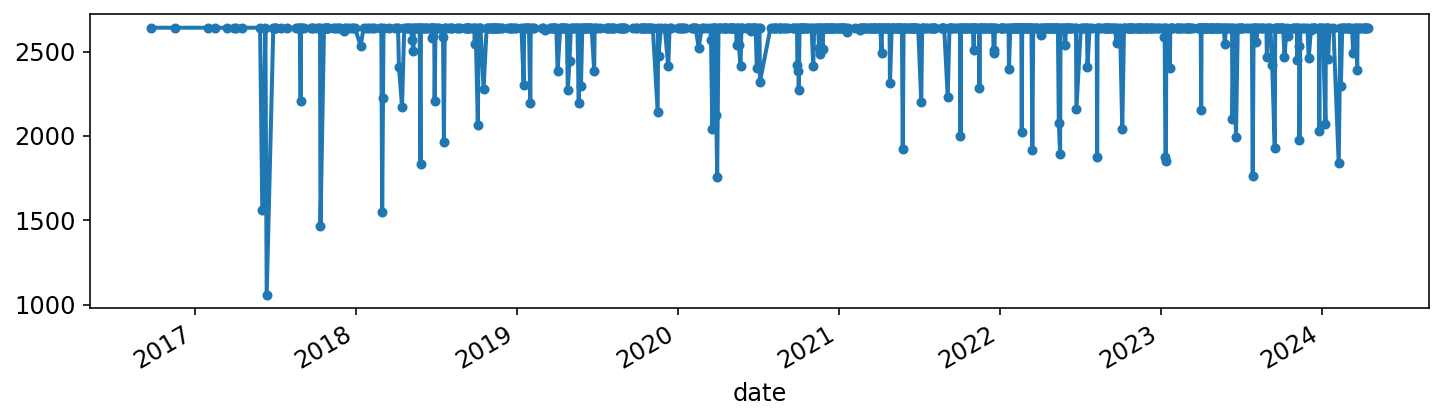

In [261]:
(df_alldates.groupby('date').predict.count()).plot(lw=2,marker='o',
                                                        figsize = (12,3),markersize = 4,label='model')

In [292]:
df_alldates.to_csv('alldates_cienega.csv')

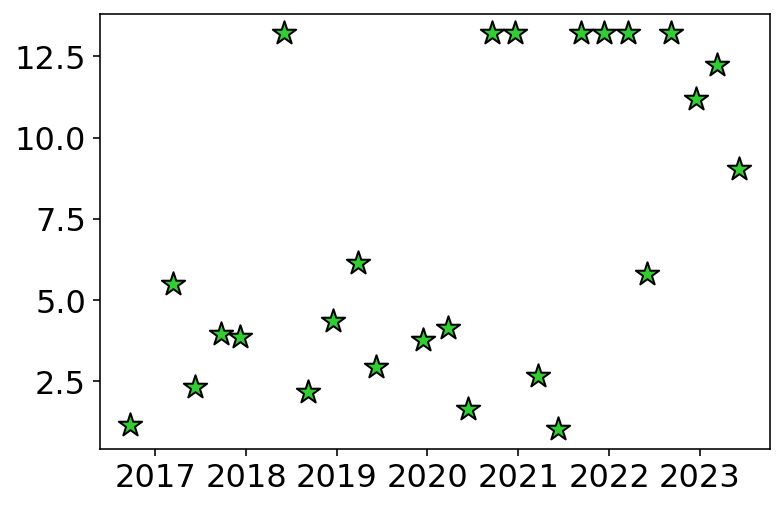

In [293]:
plt.scatter(survey_info.date.values,survey_info.wetdry.values,
           c='limegreen',marker='*',s=150,label='survey',zorder = 100,
          edgecolor = 'k')

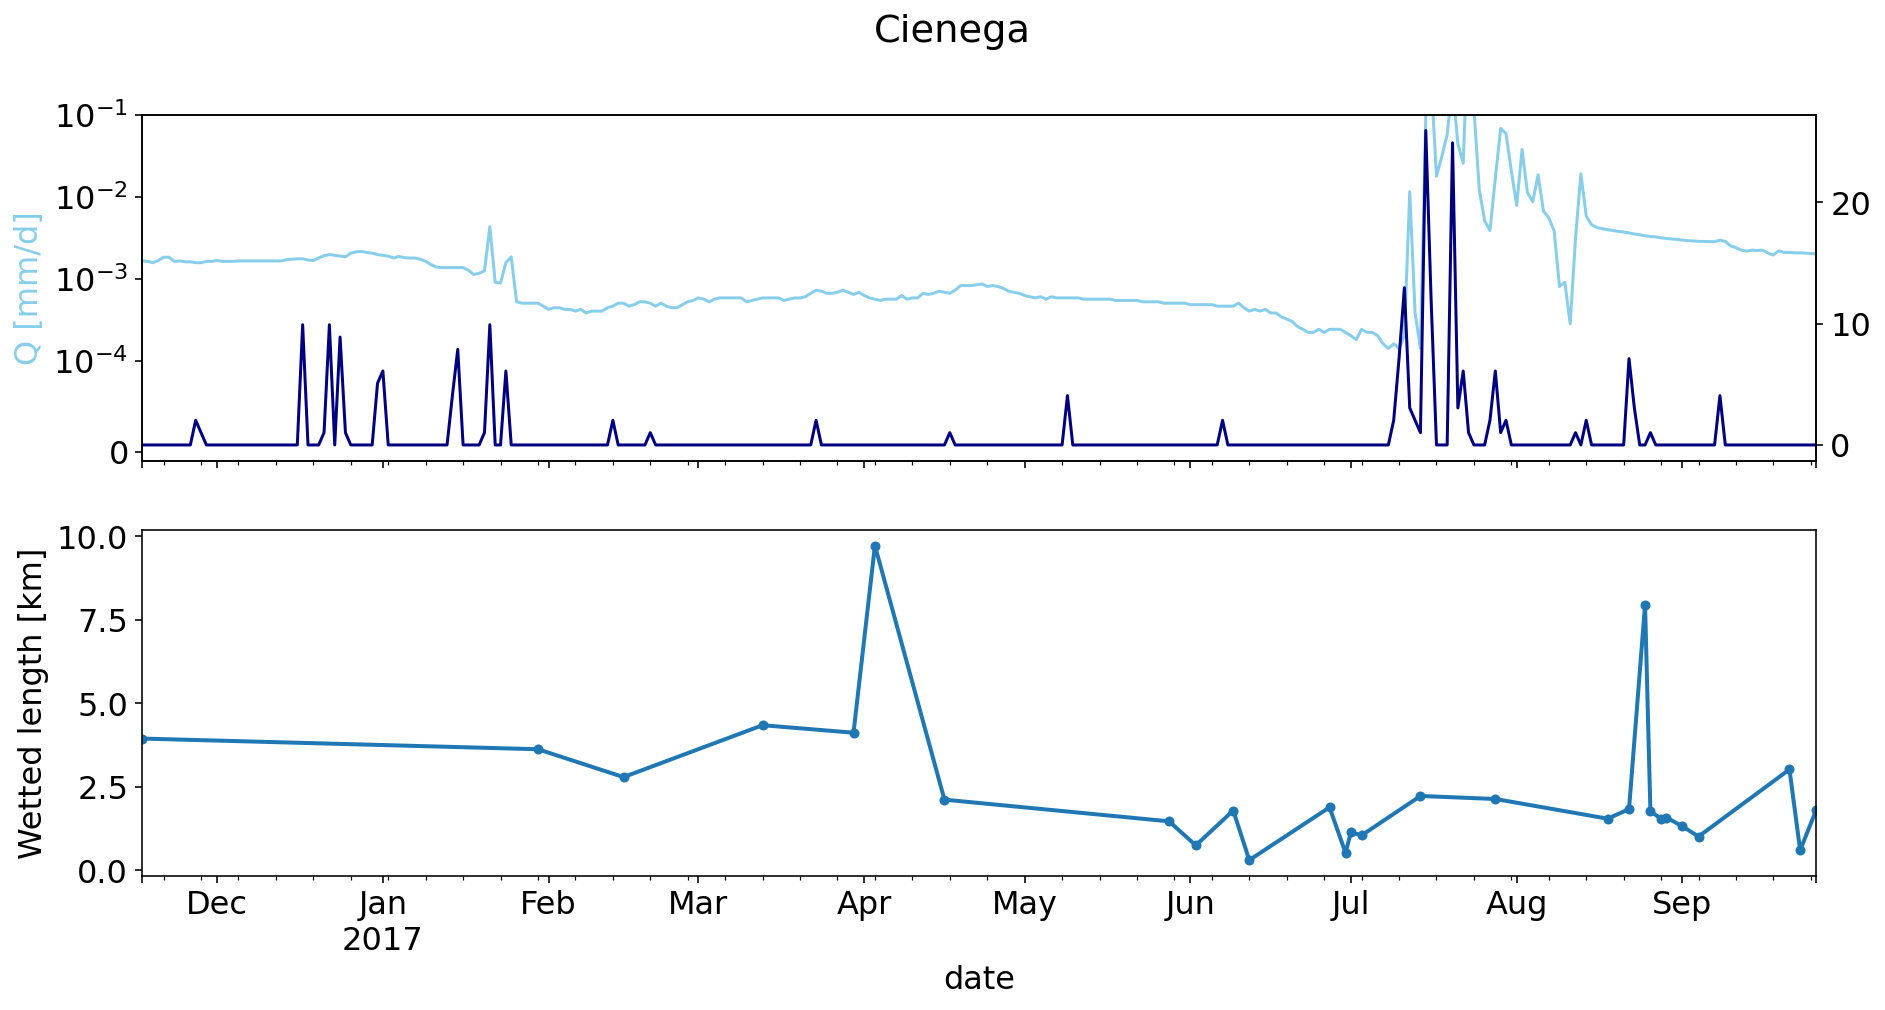

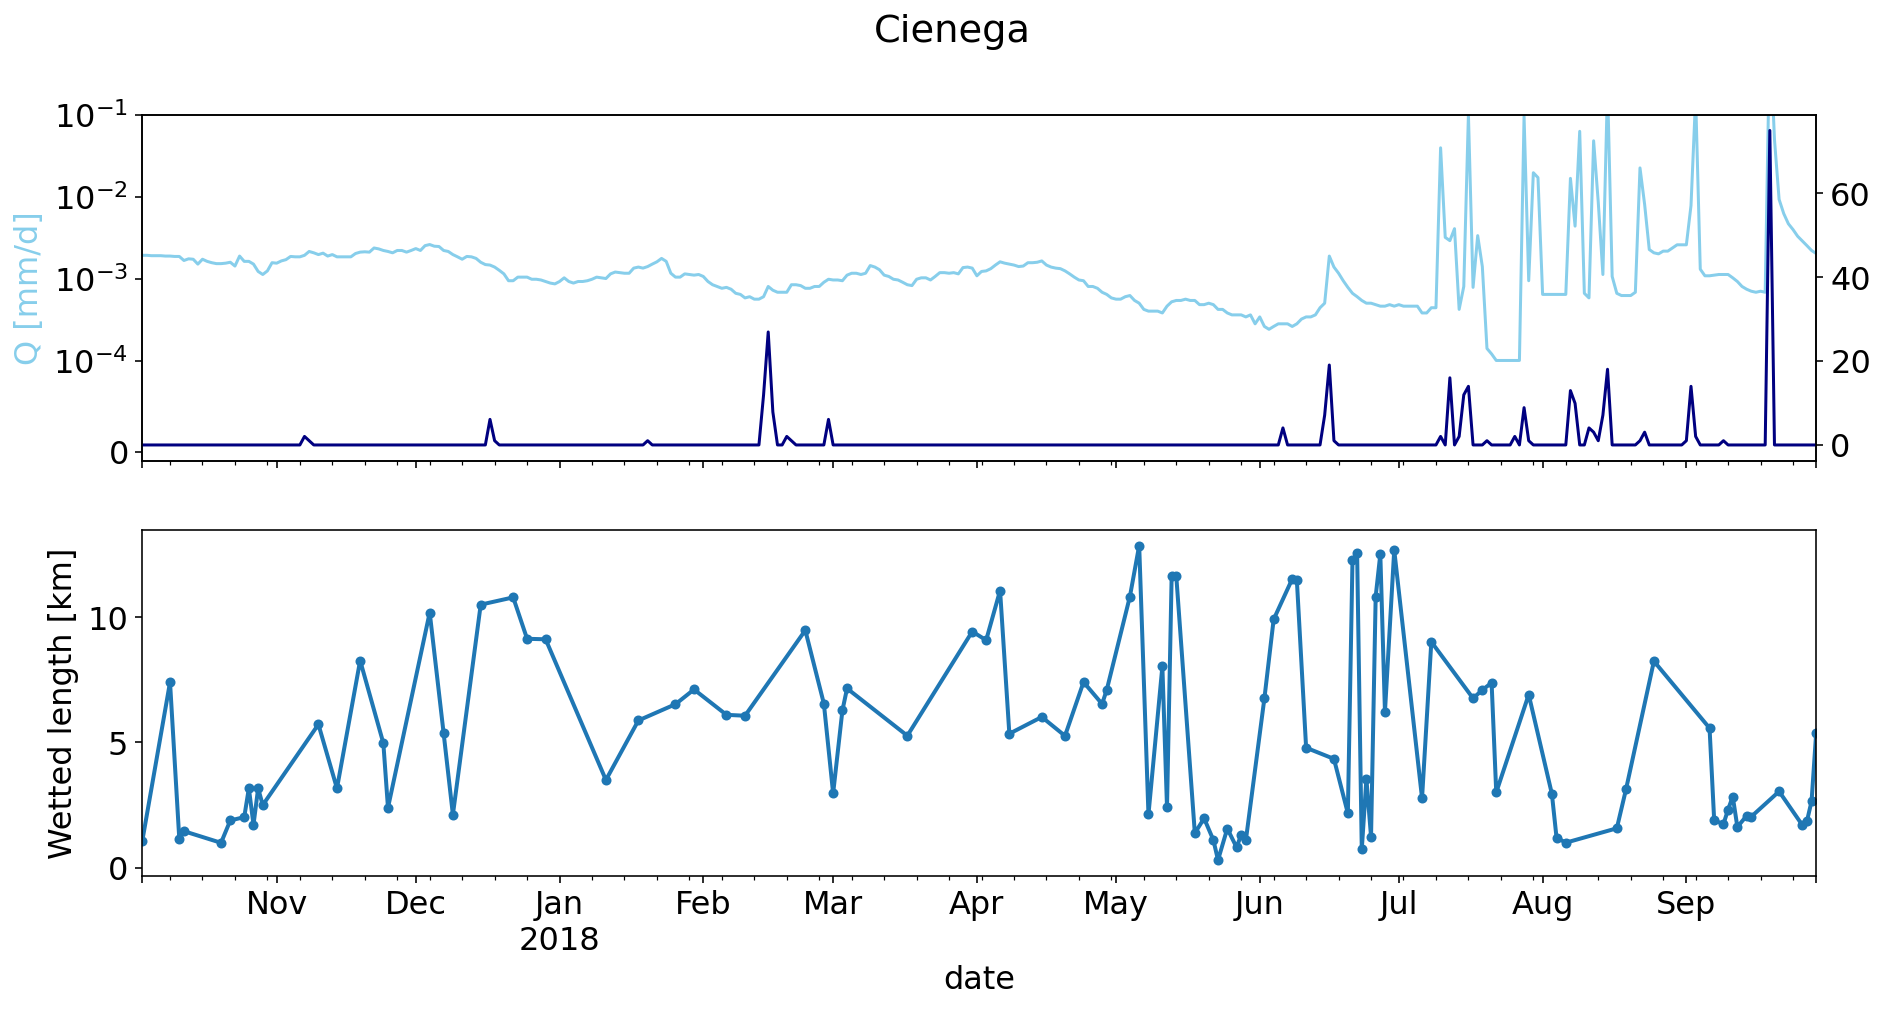

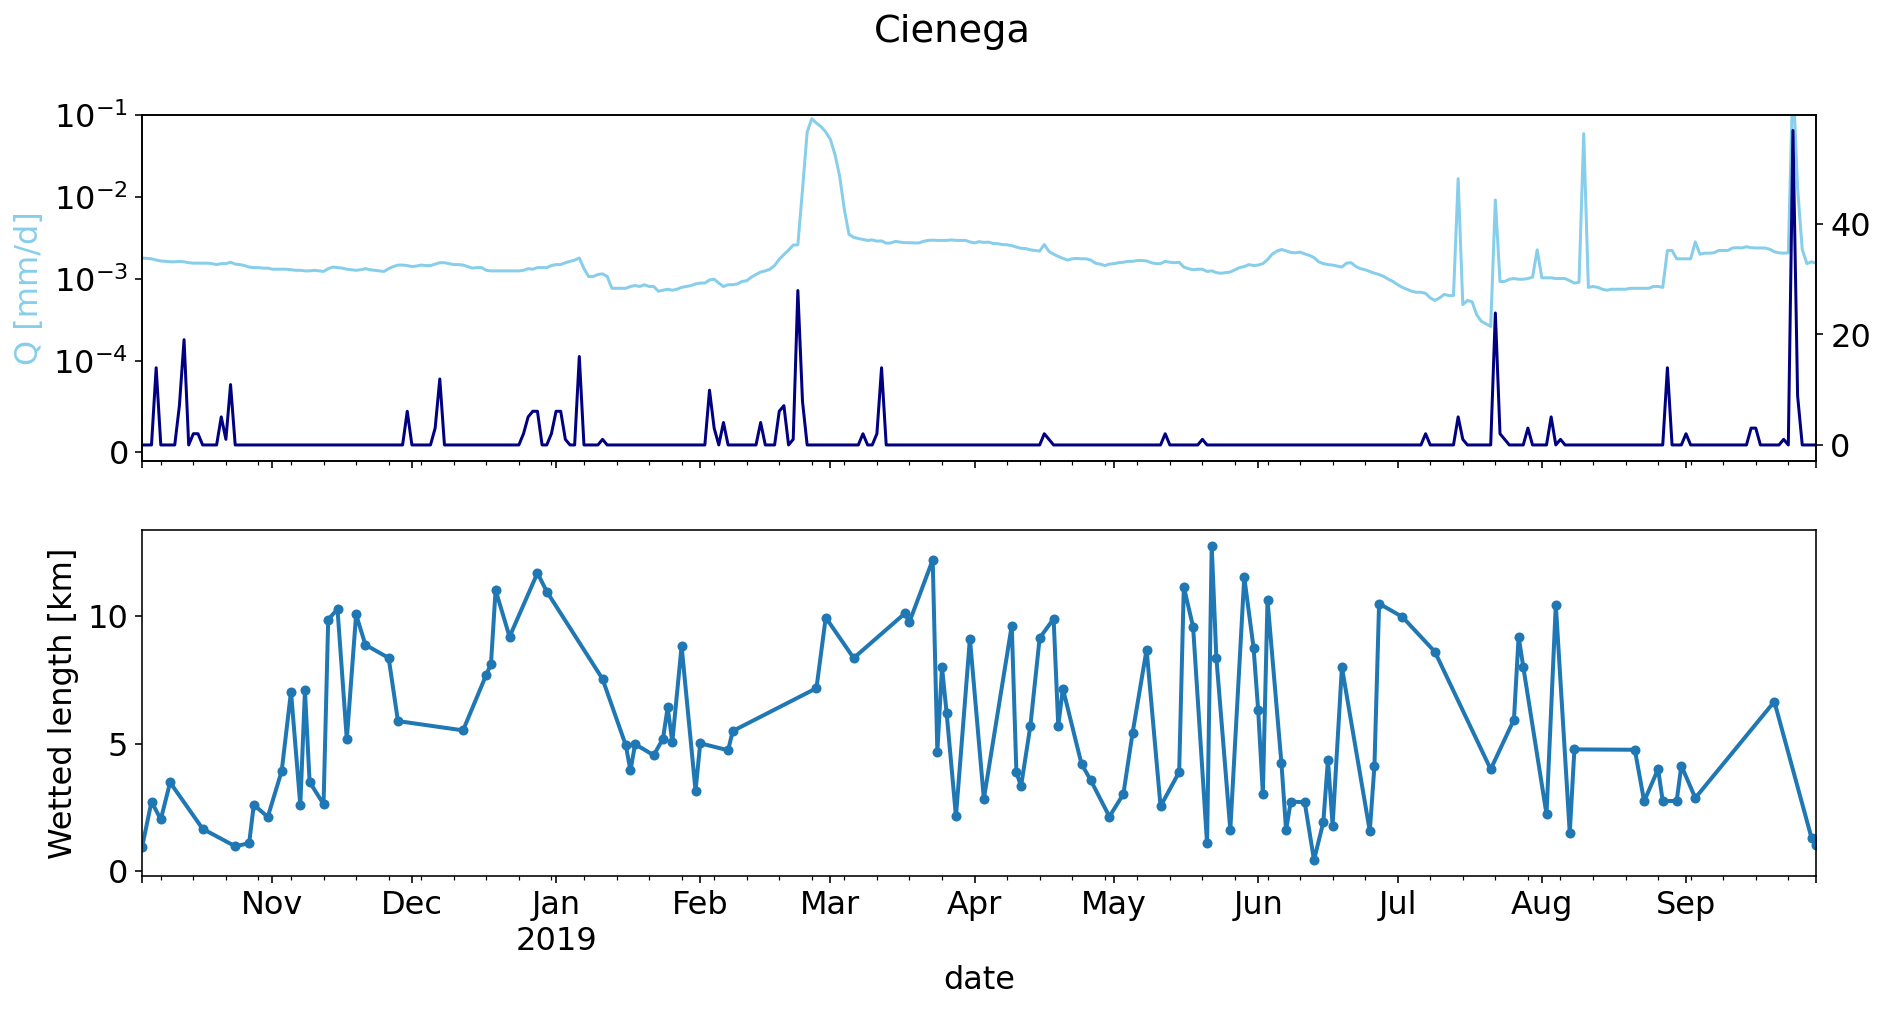

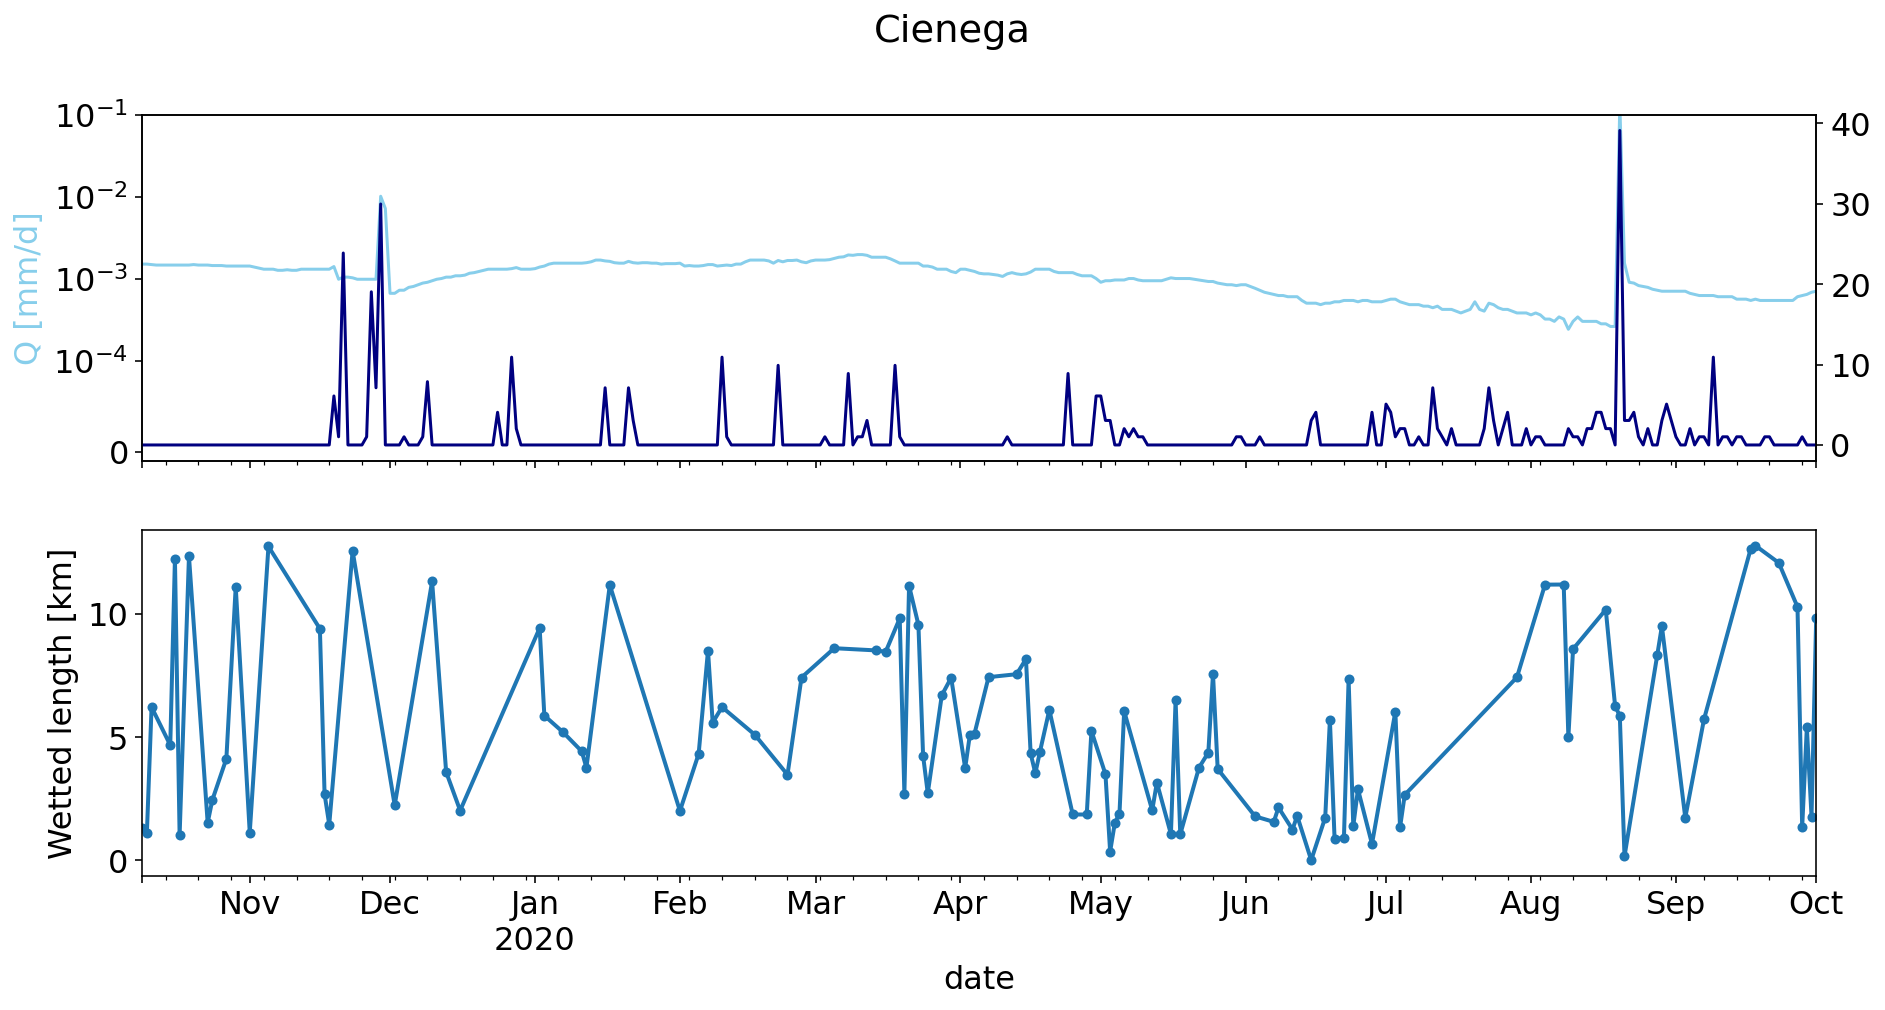

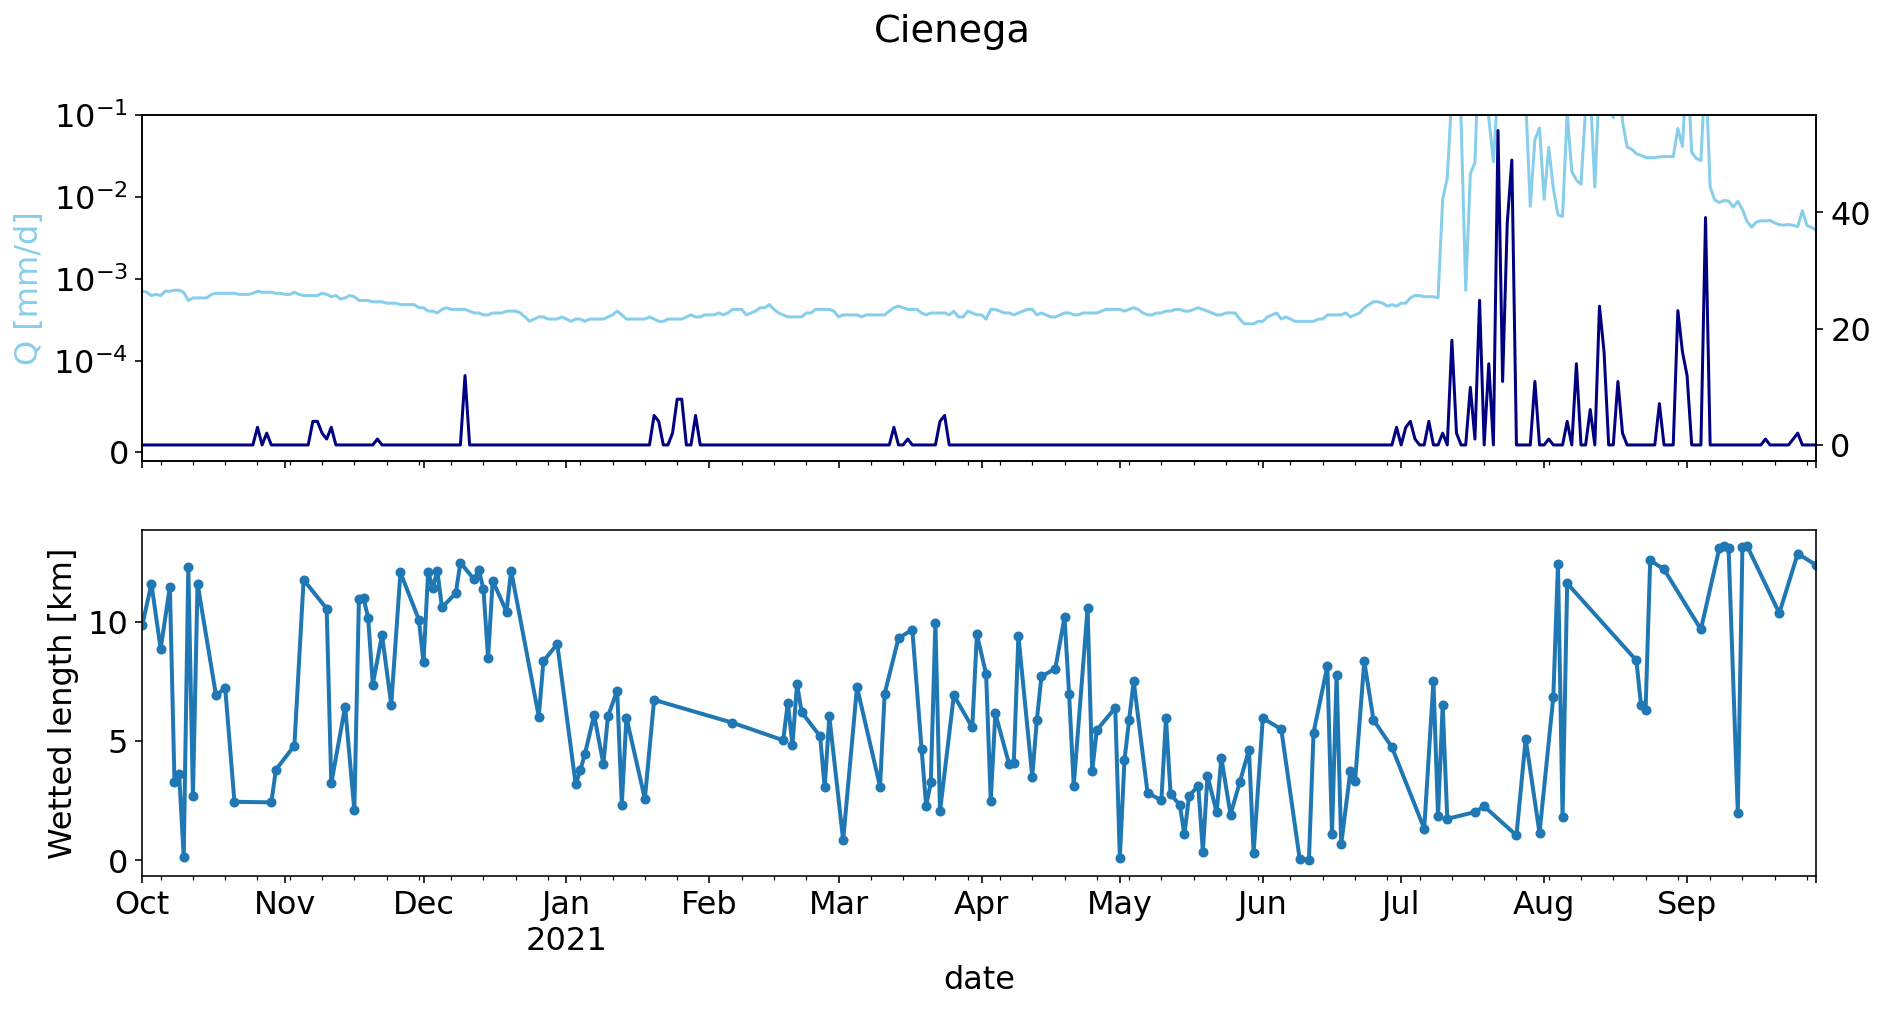

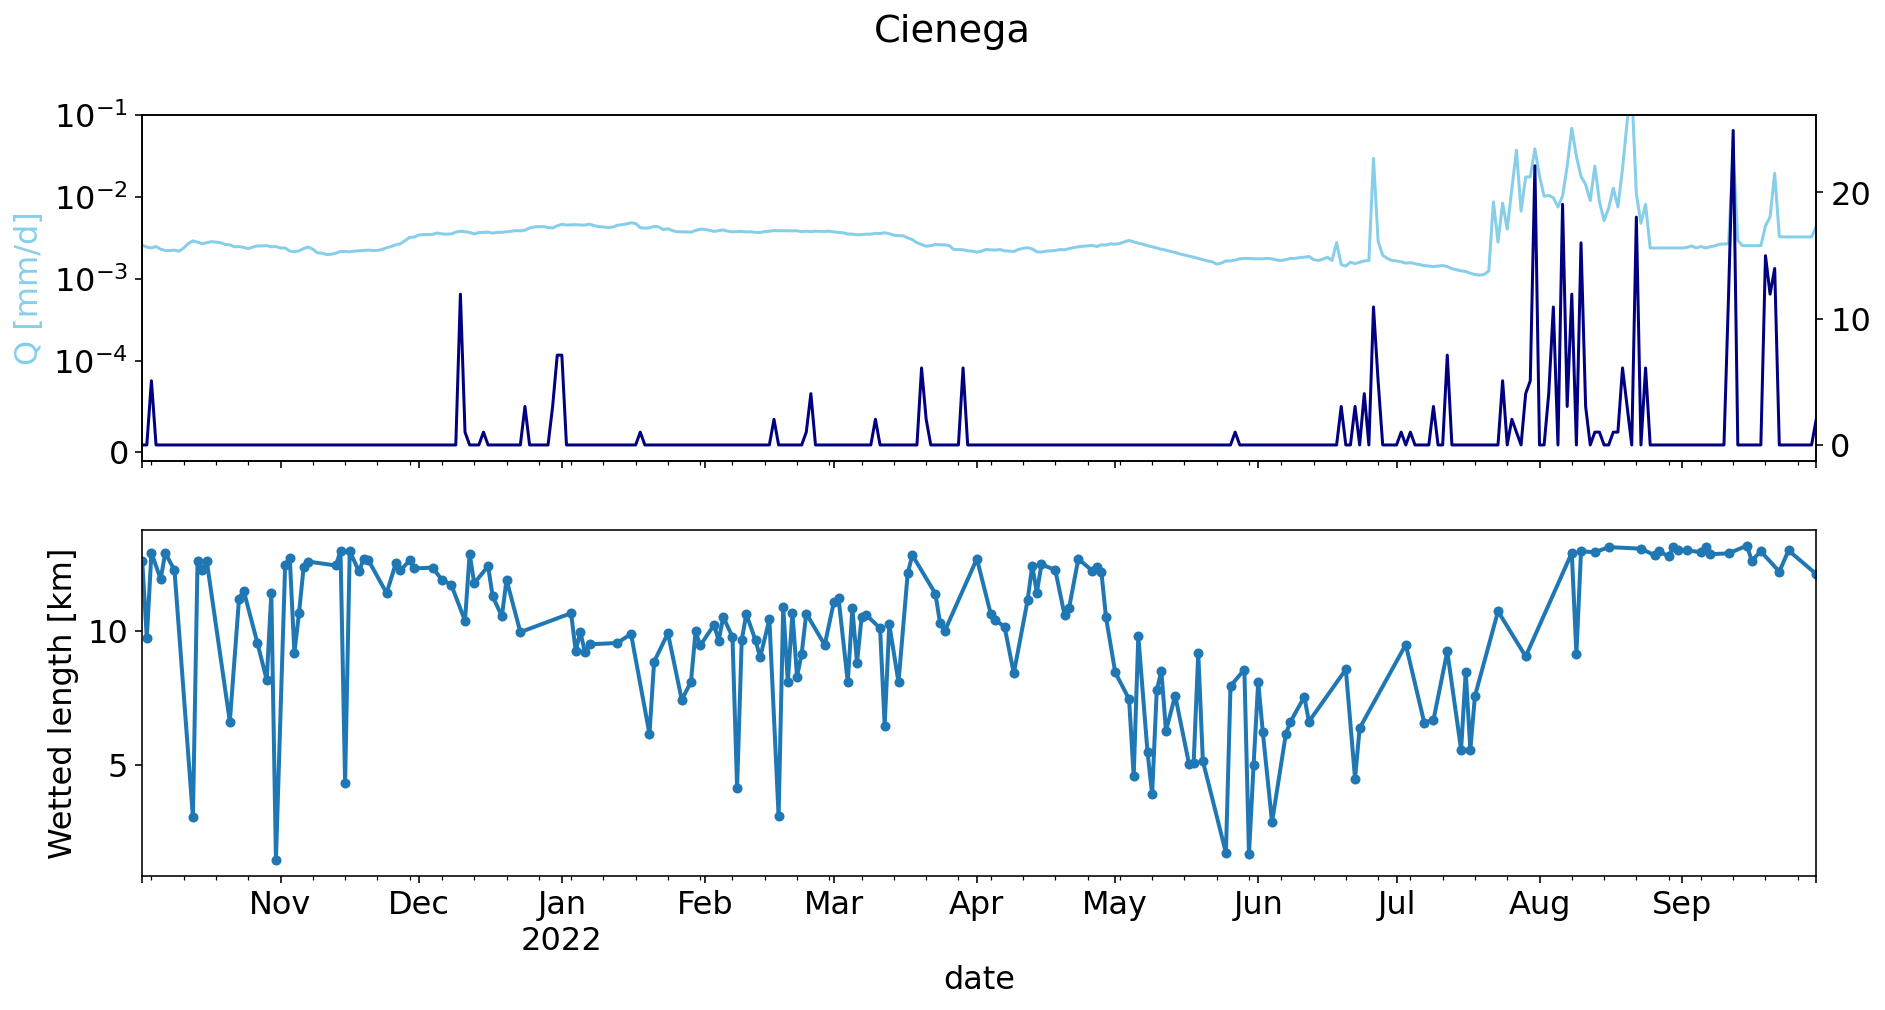

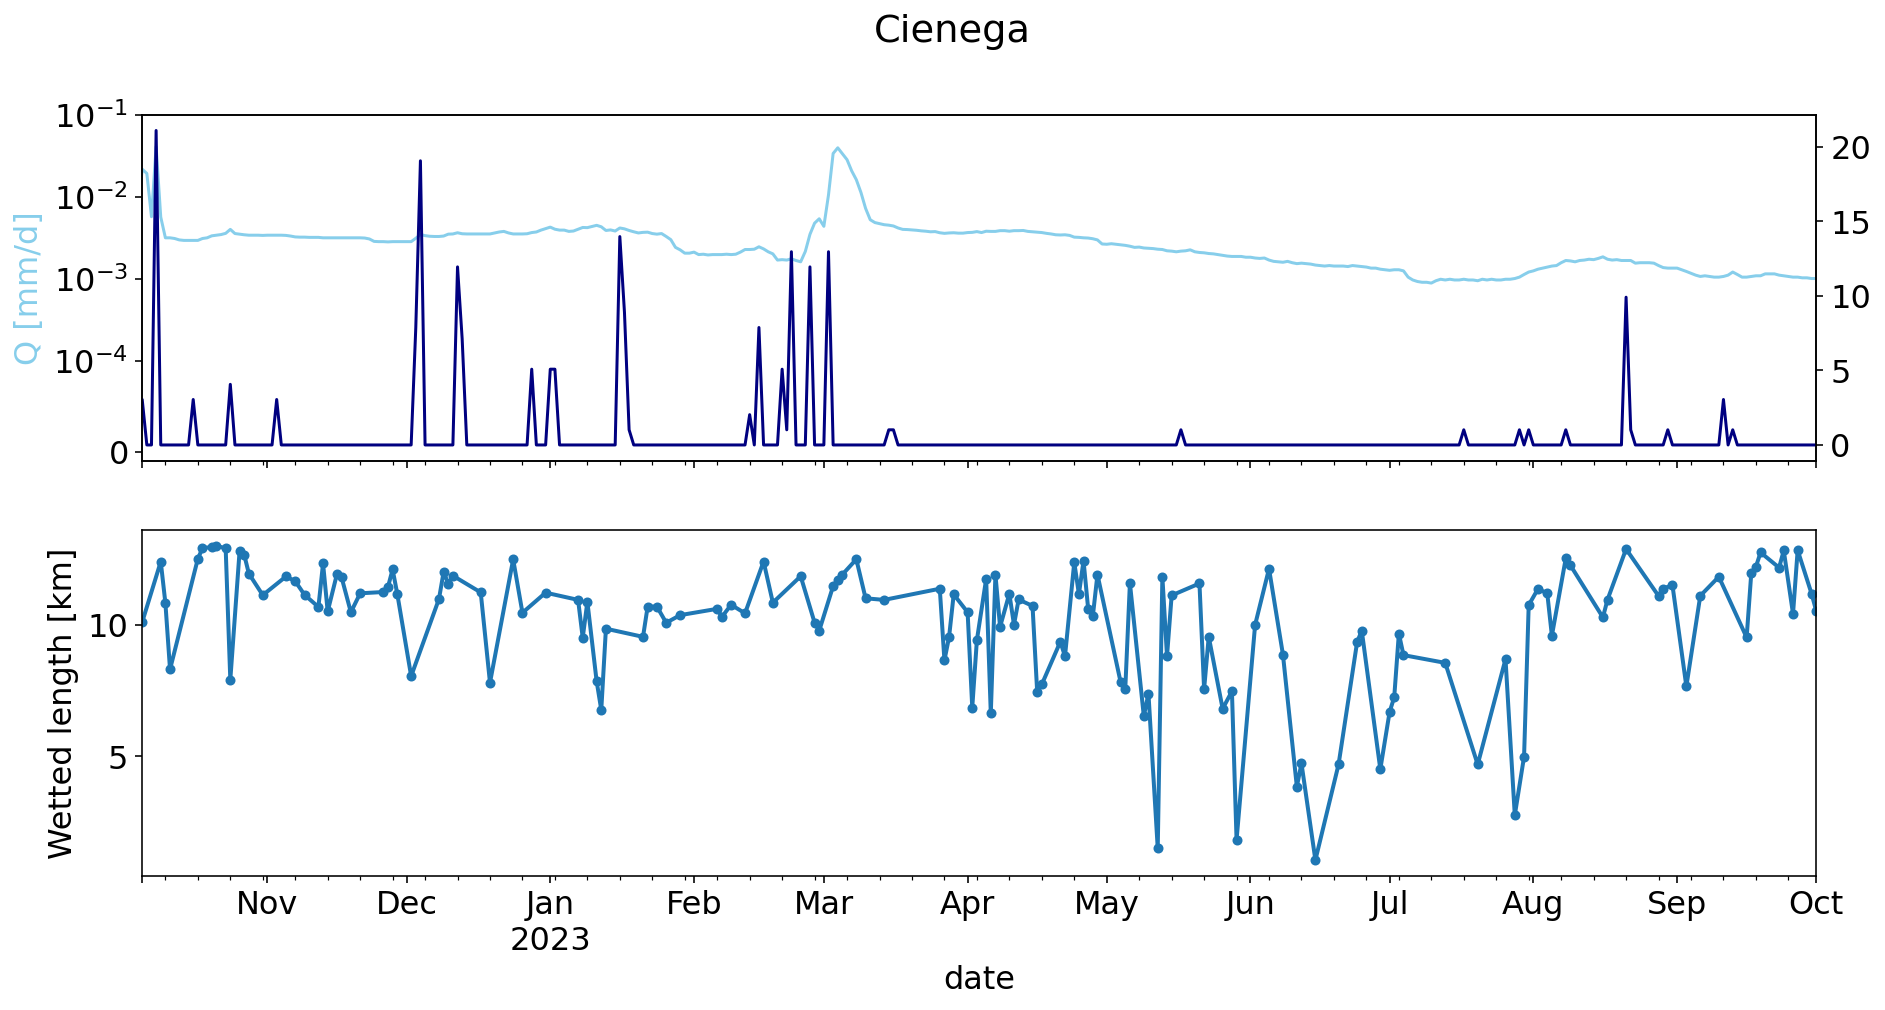

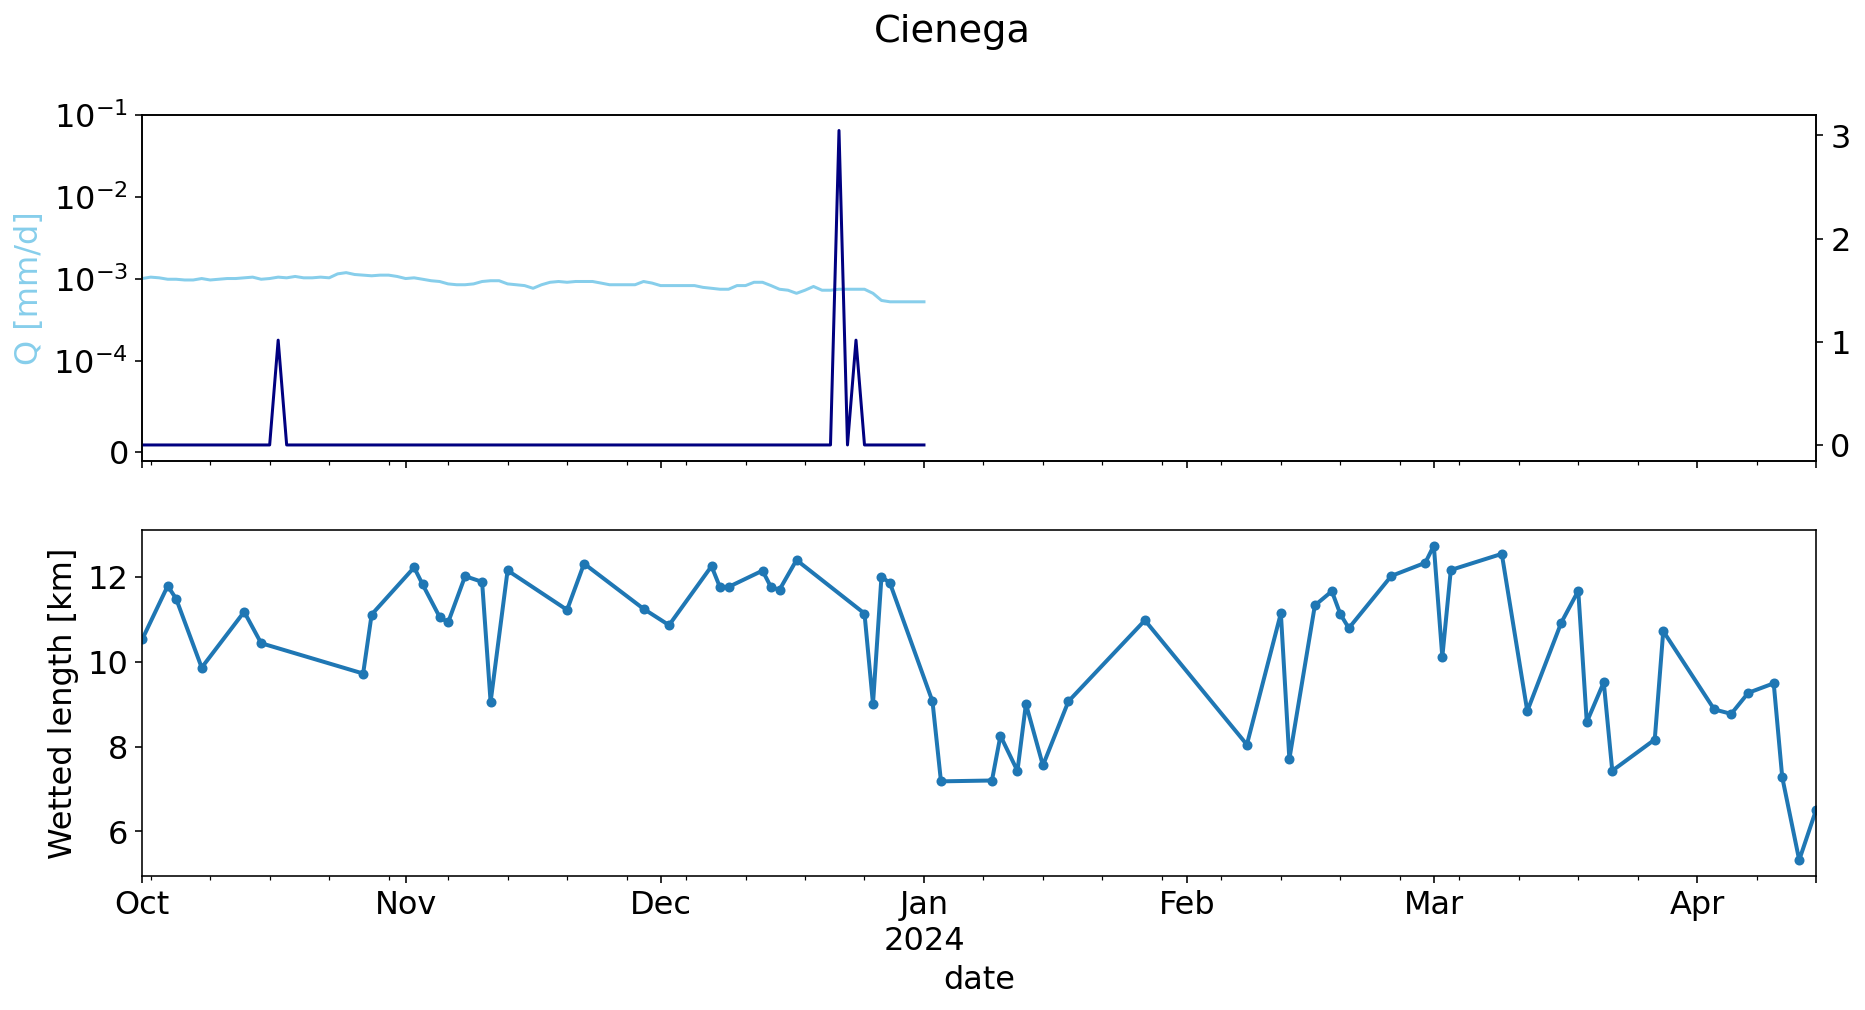

In [115]:
for y in range(2017,2025):
    fig,axs = plt.subplots(2,figsize = (15,7),sharex=True)
    ax = axs[0]
    hydro['Q [mm/d]'].loc['10-1-'+str(y-1):'10-1-'+str(y)].plot(ax=ax,c='skyblue')
    ax.set_yscale('symlog',linthresh=0.0001)
    ax.set_ylim(-.00001,0.1)
    ax.set_ylabel('Q [mm/d]',c='skyblue')
    axt = ax.twinx()
    hydro['P [mm]'].loc['10-1-'+str(y-1):'10-1-'+str(y)].plot(ax=axt,c='navy')
    # ax

    ax = axs[1]
    (df_alldates.groupby('date').predict.sum()*5/1000).loc['10-1-'+str(y-1):'10-1-'+str(y)].plot(ax=ax,lw=2,marker='o',markersize = 4)
    ax.set_ylabel('Wetted length [km]')

    fig.suptitle(site)

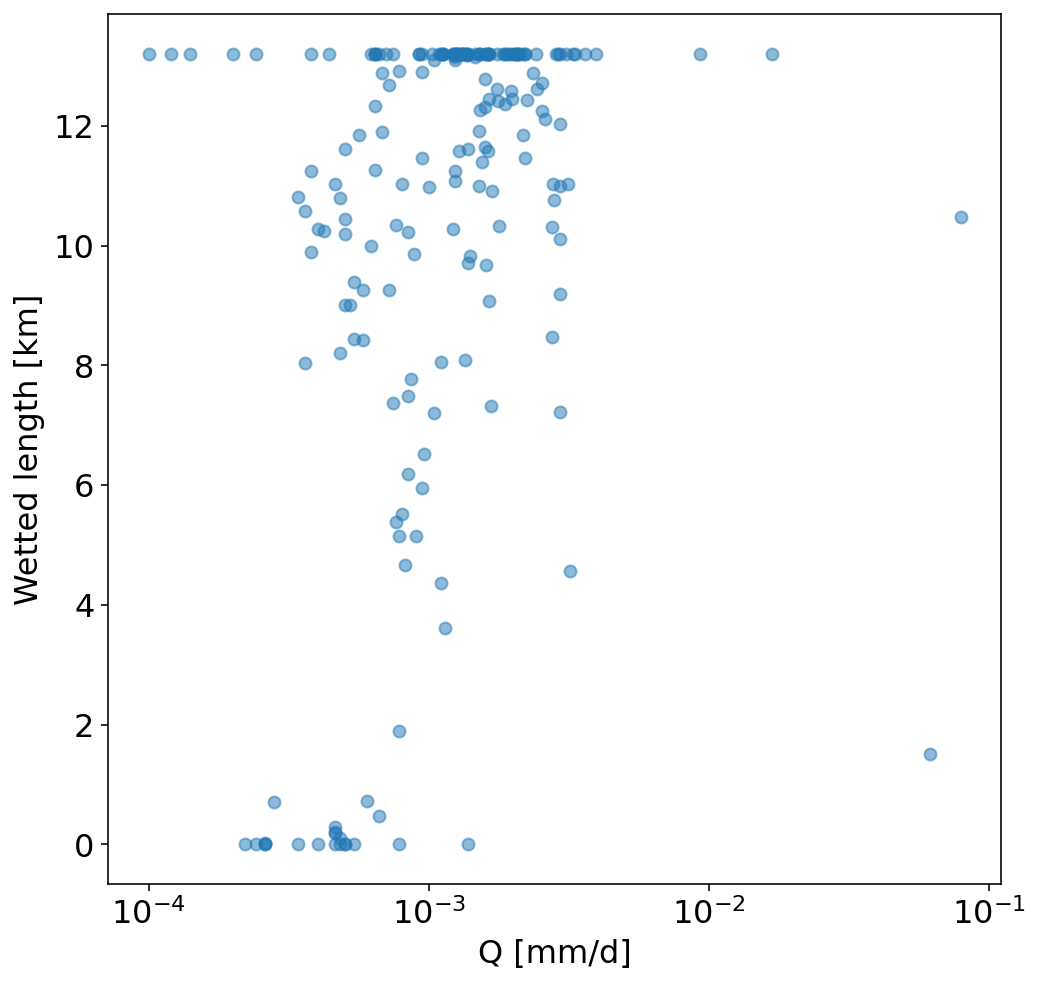

In [20]:
hydroAll = df_alldates.groupby('date')[['predict']].sum().reset_index().merge(hydro,left_on='date',right_index=True)
hydroAll['predict'] = hydroAll.predict*5/1000
hydroAll = hydroAll.loc[:'2023-10-01']

fig,ax = plt.subplots(1,figsize = (8,8))
ax.scatter(hydroAll['Q [mm/d]'],hydroAll.predict,alpha=.5)
ax.set_xlabel('Q [mm/d]')
ax.set_ylabel('Wetted length [km]')
ax.set_xscale('symlog',linthresh=.0001)

## Context

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52751/703757501.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['month'] = context.acquired.dt.month
/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_52751/703757501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['date'] = pd.to_datetime(context.date)


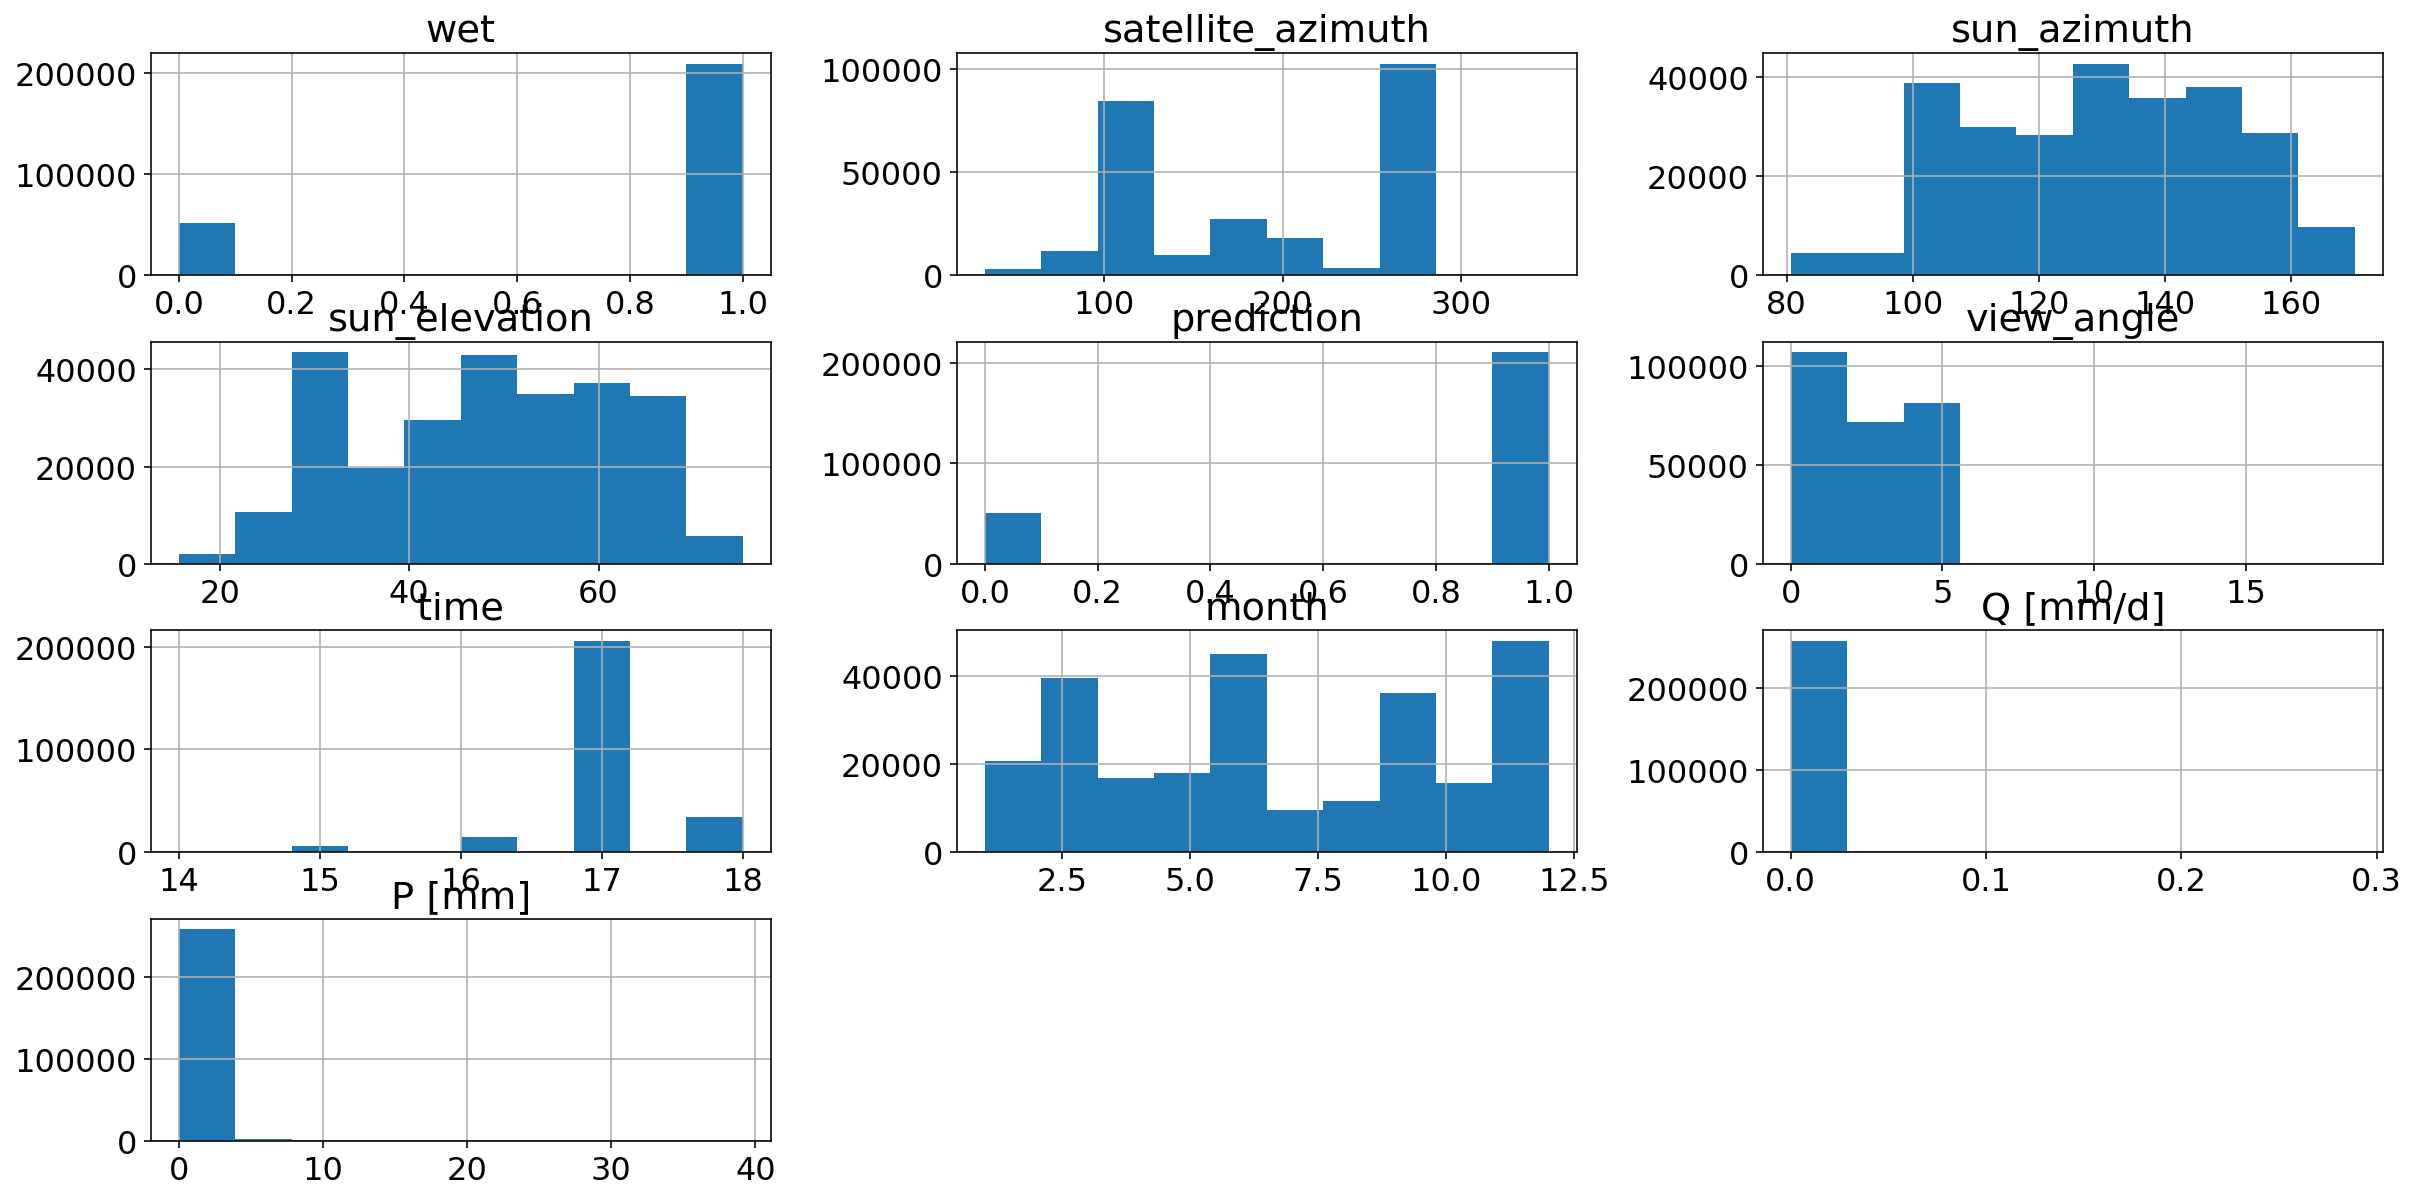

In [741]:
context_features = ['date',
                    'wet',
                    'acquired',
                    'satellite_azimuth','satellite_id',
                    'sun_azimuth','sun_elevation','prediction',
   'view_angle','time',
              'month'
             ]
context_use = [c for c in context_features if c not in ['date','acquired',
                                                       'satellite_id','prediction']]+['Q [mm/d]','P [mm]']
df['month'] = pd.to_datetime(df.date).dt.month
context = df[context_features]
context['month'] = context.acquired.dt.month
context['date'] = pd.to_datetime(context.date)
context = context.merge(hydro,left_on='date',right_index=True)
context.drop(columns=['date','acquired','satellite_id'],inplace=True)
context.hist(figsize = (20,10))
context['Q [mm/d]'] = np.log(context['Q [mm/d]']).fillna(0)
context['Q [mm/d]'] = np.where(np.isfinite(context['Q [mm/d]']),
                              context['Q [mm/d]'],0)

## Rank context features

In [893]:
# first, get I(L,Ck) for one feature

def categorize(df,feature):
    featuremax = df[feature].max()
    featuremin = df[feature].min()
    numcats = int((featuremax-featuremin)/10)+1
    diff = (featuremax-featuremin)/10
#     print(feature,diff)
    for i in range(11):
        if i==0:
            featurelist = np.where((df[feature]>=featuremin) & (df[feature]<featuremin+diff*(i+1)),
                                   i,-1)
        else:
            featurelist = np.where((df[feature]>=featuremin+diff*i) & (df[feature]<featuremin+diff*(i+1)),
                                   i,featurelist)
    return featurelist
        
def mutual_information_contexts(df1,feature1,feature2):
    df = df1.copy()
    context_vals = []
#     if len(df[feature])>10:
#         df[feature] = categorize(df,feature)
    for c in df[feature1].unique():
        dfsub = df[df[feature1]==c]
        for c1 in df[feature2].unique():
            prob = len(dfsub[dfsub[feature2]==c1])/len(df)
            probl = len(df[df[feature2]==c1])/len(df)
            probc = len(dfsub)/len(df)
            if (prob==0)|(probl==0)|(probc==0):
                mval = 0
            else:
                mval = prob*np.log2(prob/probl/probc)
            context_vals.append(mval)
    rval =  np.sum(context_vals)
    return (rval)

def mutual_information_loss(df1,cc,):
    df = df1.copy()
    num_iters = 1
    for c in cc:
        if len(df[c].unique())>12:
            df[c] = categorize(df,c)
        num_iters  = num_iters*len(df[c].unique())
    cats = {c:df[c].unique() for c in cc}
    mult = 1
    for repnum,c in enumerate(cats.keys()):
        repnum+=1
        repnum = mult
        mult = mult*len(cats[c])
        cats[c] = np.array([np.array([cats[c][i]]*repnum) for i in range(len(cats[c]))]*int(num_iters/len(cats[c])/repnum)).flatten()
    cats = pd.DataFrame.from_dict(cats)
    
    context_vals = []
    for i in range(len(cats)):
        dfsub = df[df[cats.columns[0]]==cats[cats.columns[0]].values[i]]
        for col in cats.columns[1:]:
            dfsub = dfsub[dfsub[col]==cats[col].values[i]]
        
        # prob success (loss=0)
        prob = len(dfsub[dfsub.wet==dfsub.prediction])/len(df)
        probl = len(df[df.wet==df.prediction])/len(df)
        probc = len(dfsub)/len(df)
        if (probl==0)|(probc==0)|(prob==0):
            mval = 0
        else:   
            mval = prob*np.log2(prob/probl/probc)
        context_vals.append(mval)

        # prob failure (loss=1)
        prob = len(dfsub[dfsub.wet!=dfsub.prediction])/len(df)
        probl = len(df[df.wet!=df.prediction])/len(df)
        probc = len(dfsub)/len(df)
        if (prob==0)|(probc==0)|(prob==0):
            mval = 0
        else:
            mval = prob*np.log2(prob/probl/probc)
        context_vals.append(mval)
    rval =  np.sum(context_vals)
    return (rval)

def deltaI(df1,cc):
    df = df1.copy()
    mutual_info = mutual_information_loss(df,cc)
    mutual_context_info = 0
    for i in range(len(cc)-1):
        mutual_context_info += mutual_information_contexts(df,cc[i],cc[-1])
    return mutual_info-mutual_context_info

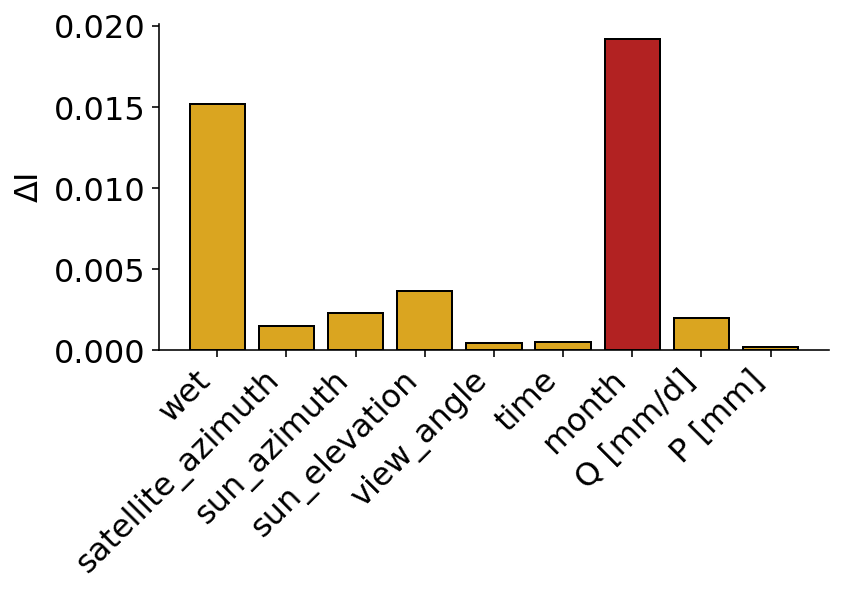

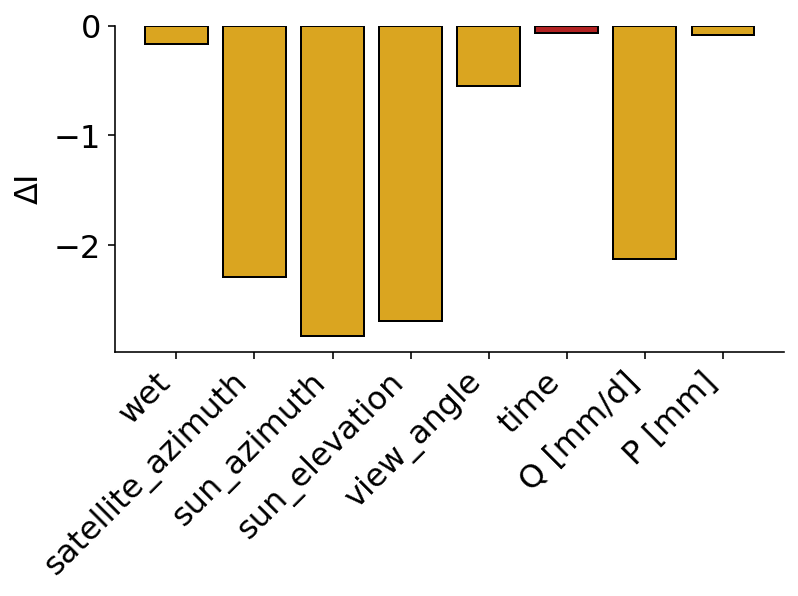

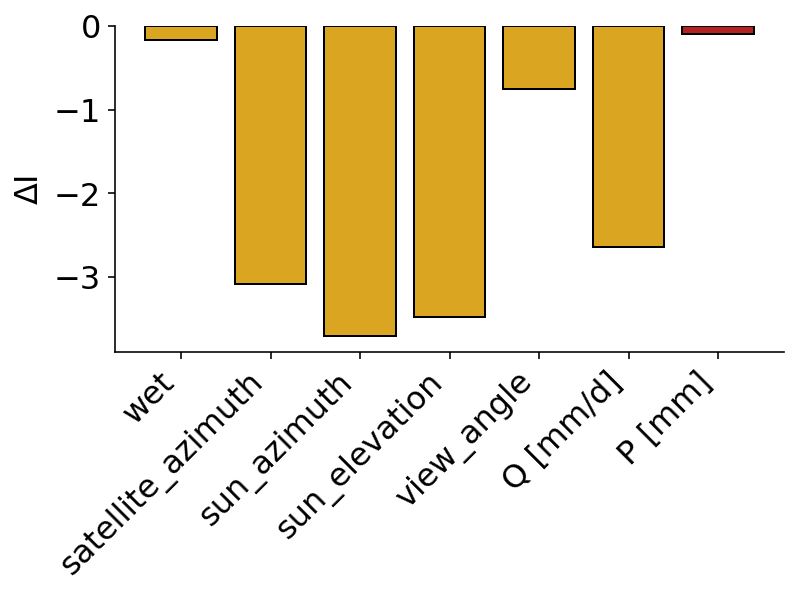

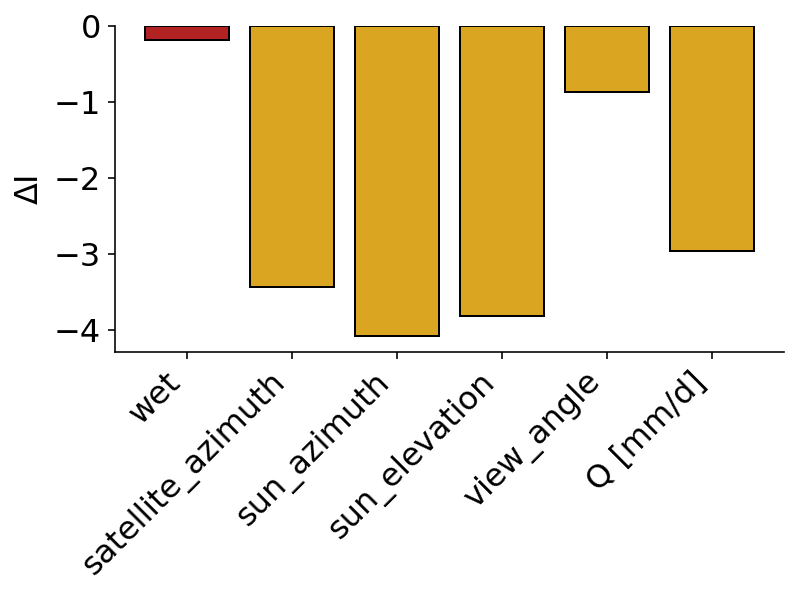

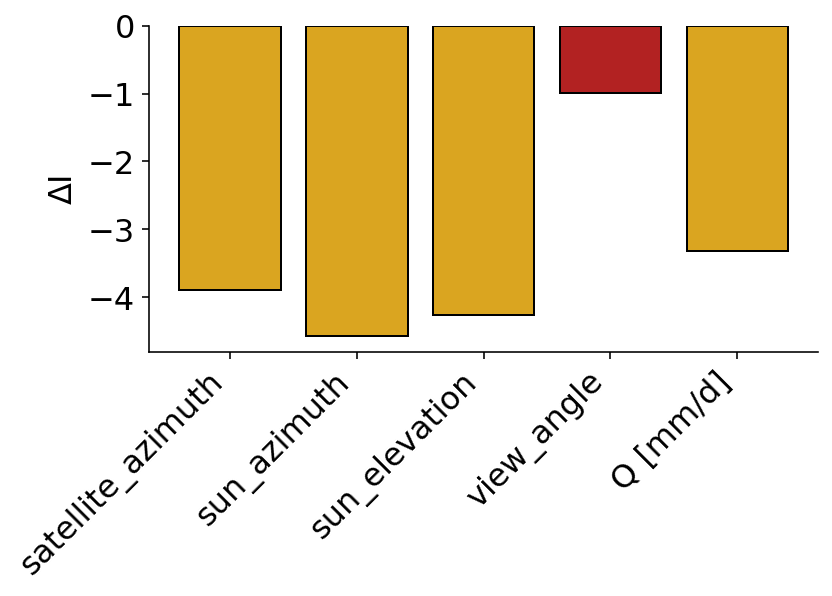

In [895]:
# rank context features in terms of importance for determining loss
context_features_ranked = []
for i in range(5):#len(context_use)-1):
    infos = {}
    for c in [c for c in context_use if c not in context_features_ranked]:
        infos[c] = [deltaI(context,context_features_ranked + [c])]
    infos = pd.DataFrame.from_dict(infos)
    
    fig,ax = plt.subplots(1,figsize = (6,3))
    for j,c in enumerate(infos.columns):
        if infos[c].values[0]==infos.T.max().values[0]:
            color = 'firebrick'
            context_features_ranked.append(c)
        else:
            color = 'goldenrod'
        ax.bar(j,infos[c].values[0],facecolor = color,edgecolor = 'k')
    ax.set_xticks(list(range(j+1)))
    ax.set_xticklabels(infos.columns,rotation=45,ha='right')
    ax.set_ylabel('$\Delta$I')
    ax.spines[['top','right']].set_visible(False)
    plt.show()
    

In [900]:
context_features_ranked = ['month','wet','P [mm]','time','view_angle']

## Calculate space dimensionality

In [901]:
def calc_loss(yfit,y):
    losses = np.nanmean(np.where(yfit!=y,1,0))
    return losses

def gk(df1,context_set,dfval1):
    df = df1.copy()
    dfval = dfval1.copy()
    
    # get set of contexts to explore
    num_iters = 1
    for c in context_set:
        if len(df[c].unique())>12:
            df[c] = categorize(df,c)
        num_iters  = num_iters*len(df[c].unique())
    cats = {c:df[c].unique() for c in context_set}
    mult = 1
    for repnum,c in enumerate(cats.keys()):
        repnum+=1
        repnum = mult
        mult = mult*len(cats[c])
        cats[c] = np.array([np.array([cats[c][i]]*repnum) for i in range(len(cats[c]))]*int(num_iters/len(cats[c])/repnum)).flatten()
    cats = pd.DataFrame.from_dict(cats)
    
    # do calculation
    gkvals = []
    pvals = []
    
    for i in range(len(cats)):
        dfsub = df[df[cats.columns[0]]==cats[cats.columns[0]].values[i]]
        dfsubval = dfval[dfval[cats.columns[0]]==cats[cats.columns[0]].values[i]]
        for col in cats.columns[1:]:
            dfsub = dfsub[dfsub[col]==cats[col].values[i]]
            dfsubval = dfsubval[dfsubval[col]==cats[col].values[i]]
        
        if len(dfsub)==0:
            gkvals.append(1)
        else:
            gkvals.append(len(dfsub[dfsub.wet!=dfsub.prediction])/len(dfsub))
        if len(dfval)==0:
            pvals.append(0)
        else:
            pvals.append(len(dfsubval)/len(dfval))
        
    gkvals = np.array(gkvals)
    pvals = np.array(pvals)
#     print(gkvals)
#     print(pvals)
#     print(np.nansum(pvals*gkvals))
    
    return np.nansum(pvals*gkvals)

In [902]:
eKs = []
for i in range(1,len(context_features_ranked)+1):
    print('Number of context features:',i)
    cc = context_features_ranked[:i]
    eK = []
    for j in range(10):
        print('     iteration ',j)
        Xfit, Xval, yfit, yval = train_test_split(context,context['prediction'],)
        eK.append(abs(calc_loss(Xfit.prediction,Xfit.wet)-gk(Xfit,cc,Xval)))
    eK = np.nanmean(eK)
    eKs.append(eK)
    print('     eK =',round(eK,3))

Number of context features: 1
     iteration  0
     iteration  1
     iteration  2
     iteration  3
     iteration  4
     iteration  5
     iteration  6
     iteration  7
     iteration  8
     iteration  9
     eK = 0.0
Number of context features: 2
     iteration  0
     iteration  1
     iteration  2
     iteration  3
     iteration  4
     iteration  5
     iteration  6
     iteration  7
     iteration  8
     iteration  9
     eK = 0.0
Number of context features: 3
     iteration  0
     iteration  1
     iteration  2
     iteration  3
     iteration  4
     iteration  5
     iteration  6
     iteration  7
     iteration  8
     iteration  9
     eK = 0.001
Number of context features: 4
     iteration  0
     iteration  1
     iteration  2
     iteration  3
     iteration  4
     iteration  5
     iteration  6
     iteration  7
     iteration  8
     iteration  9
     eK = 0.001
Number of context features: 5
     iteration  0
     iteration  1
     iteration  2
     iteration  

Text(0.5, 1.0, 'Cienega')

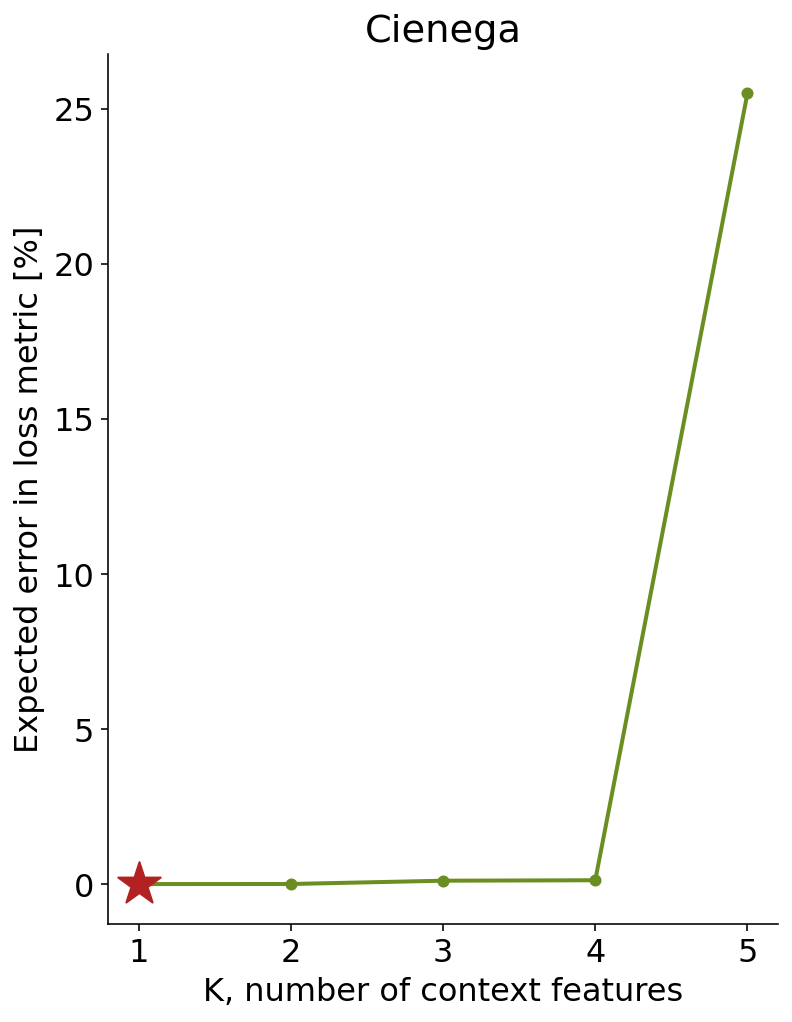

In [903]:
fig,ax = plt.subplots(1,figsize = (6,8))
eKs = eKs[:5]
ax.plot(list(range(1,len(eKs)+1)),np.array(eKs)*100,marker='o',c='olivedrab',lw=2,markersize=5)
num_use = np.argmin(eKs)
val = np.min(eKs)
ax.scatter([num_use+1],[val*100],c='firebrick',s=500,marker='*',zorder=100)
ax.set_xticks(list(range(1,len(eKs)+1)))
ax.set_xlabel('K, number of context features')
# ax.set_ylim(0,3)
ax.set_ylabel('Expected error in loss metric [%]')
ax.spines[['top','right']].set_visible(False)
ax.set_title('Cienega')

# Estimate loss on unseen data

In [890]:
def gk_estimate(df1,context_set):
    df = df1.copy()
       
    # get set of contexts to explore
    num_iters = 1
    for c in context_set:
        if len(df[c].unique())>12:
            df[c] = categorize(df,c)
        if c=='month':
            numuse = 12
        else:
            numuse = len(df[c].unique())
        num_iters  = num_iters*numuse
    cats = {c:df[c].unique() for c in context_set}
    cats['month'] = list(range(1,13))
    mult = 1
    for repnum,c in enumerate(cats.keys()):
        repnum+=1
        repnum = mult
        mult = mult*len(cats[c])
        cats[c] = np.array([np.array([cats[c][i]]*repnum) for i in range(len(cats[c]))]*int(num_iters/len(cats[c])/repnum)).flatten()
    cats = pd.DataFrame.from_dict(cats)
    
    # do calculation
    gkvals = []
    cols = cats.columns
    for i in range(len(cats)):
        dfsub = df.copy()
        dfsub = dfsub[dfsub[cols[0]]==cats[cols[0]].values[i]]
#         if cats.month.values[i]==11:
#             print(dfsub)
        for col in cols[1:]:
#             print(dfsub)
            dfsub = dfsub[dfsub[col]==cats[col].values[i]]
        
        if len(dfsub)>0:
            gkvals.append(len(dfsub[dfsub.wet!=dfsub.prediction])/len(dfsub))
        else:
            gkvals.append(1)
        
#         if cats.month.values[i]==12:
#             print(len(dfsub))
#             print(cats.iloc[i])
        
        
    gkvals = np.array(gkvals)
    cats['gk'] = gkvals
    
    return cats

In [891]:
# estimate model performance on unseen data
i = 3
cc = ['month','time','wet']#context_features_ranked[:i]
loss_estimates = gk_estimate(context,cc)

<Axes: xlabel='month'>

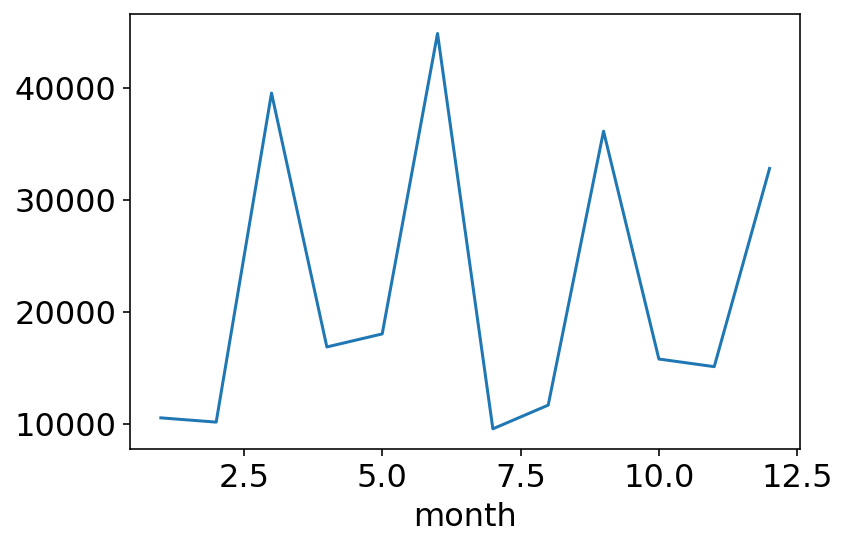

In [906]:
context.groupby(['month']).count().time.plot()#.drop_duplicates()

In [822]:
loss_estimates[(loss_estimates.month==2
               )]

,month,time,wet,gk
1,2,17,0,1.0
13,2,18,0,1.0
25,2,16,0,1.0
37,2,15,0,1.0
49,2,14,0,1.0
61,2,17,1,0.0
73,2,18,1,0.0
85,2,16,1,0.0
97,2,15,1,0.0
109,2,14,1,1.0


In [823]:
loss_estimates[['wet','month','gk']].groupby(['month','wet']).min()

gk
month wet          
1     0    0.086246
      1    0.015957
2     0    1.000000
      1    0.000000
3     0    1.000000
      1    0.000000
4     0    0.002464
      1    0.014563
5     0    1.000000
      1    0.000000
6     0    1.000000
      1    0.000000
7     0    0.054443
      1    0.000000
8     0    1.000000
      1    0.000000
9     0    1.000000
      1    0.000000
10    0    0.108556
      1    0.008759
11    0    1.000000
      1    1.000000
12    0    1.000000
      1    1.000000

In [ ]:
# no data for time = 14, but exists in data for May, June, and September
# no data for time = 15 and dry, but exists in data for all months except January and december
# no data for time = 15 and wet for June, October-December
# no data for time = 16 and dry except for January but exists for all months
# no data for time = 16 and wet for November-December
# no data for time = 17 and dry except for january but exists for all months
# no data for time = 17 and wet for November-December
# no data for time = 18 and dry except January but exists for all months
# no data for time = 18 and wet November-December


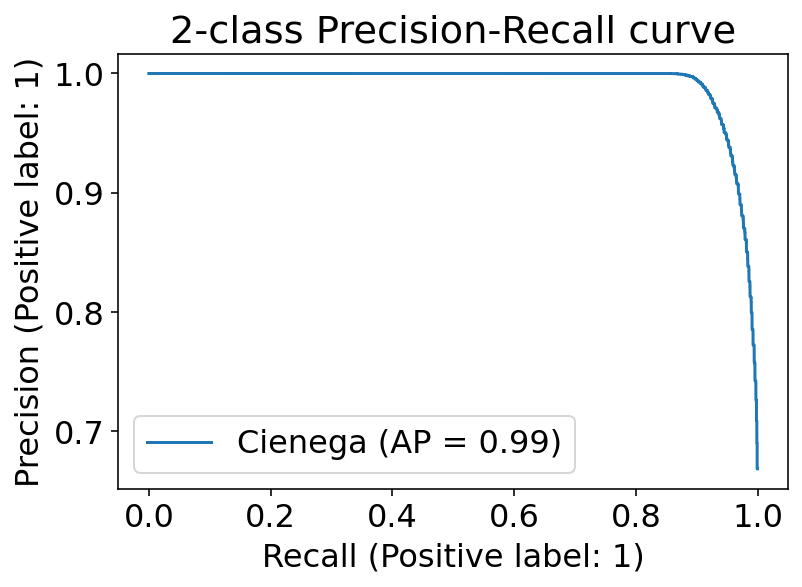

In [193]:
0

## Try running on Ramsey

In [294]:
# load imagery data
site = 'Ramsey'
if site=='Ramsey':
    df = pd.read_csv('../data/'+site+'/processed_assumptions/processed_with_dates_and_assumptions_new.csv')
df['date'] = pd.to_datetime(df.date)
df['date'] = df.date.dt.date
df = df.groupby(['x','y','date']).first().reset_index()

#load hydro data
hydro = pd.read_csv('../data/'+site+'/'+site+'HydroData.csv')
hydro['Unnamed: 0'] = pd.to_datetime(hydro['Unnamed: 0'])
hydro.set_index('Unnamed: 0',inplace=True)

# load imagery metadata
metad = pd.read_csv('../data/'+site+'/'+site+'_imagery_metadata.csv')
metad['acquired'] = pd.to_datetime(metad.acquired)
metad['doy'] = metad.acquired.dt.dayofyear
metad['time'] = metad.acquired.dt.hour
metad['date'] = metad.acquired.dt.date
metad['month'] = metad.acquired.dt.month
metad = metad.groupby('date').first().reset_index()

# load imagery summary data values
imagd = pd.read_csv('../data/'+site+'/'+site+'_imagery_summary_values.csv')
imagd['date'] = pd.to_datetime(imagd['date'],format='%Y%m%d')
imagd['date'] = imagd.date.dt.date
imagd.drop(columns='Unnamed: 0',inplace=True)
imagd = imagd.set_index('date').sort_index().reset_index().groupby('date').first().reset_index()

In [295]:
df = df.merge(imagd,on='date')

for band in ['blue','green','red','NIR']:
    if band=='NIR':
        band1 = 'nir'
    else:
        band1 = band
#     df[band] = (df[band]-df[band1+'1'].median())/(df[band1+'99'].median()-df[band1+'1'].median())
    df[band] = (df[band]-df[band1+'1'])/(df[band1+'99']-df[band1+'1'])

In [296]:
df = df.merge(metad,on='date')
df['wet'] = np.where(df.wetdry=='wet',1,0)

In [297]:
print_score(test_model,Xtest = df[features],ytest=df['wet'])

RMSE on training set, RMSE on test set, accuracy with training set, accuracy with test set,oobscore(optional)
[0.004987422616842001, 0.8128892758636879, 0.9999751256156411, 0.3392110251858093]


In [298]:
model.score(df[features], df.wet)

0.4197634880991785

In [299]:
df['prediction'] = model.predict(df[features])

Text(-110.325, 31.455000000000002, 'Comparison')

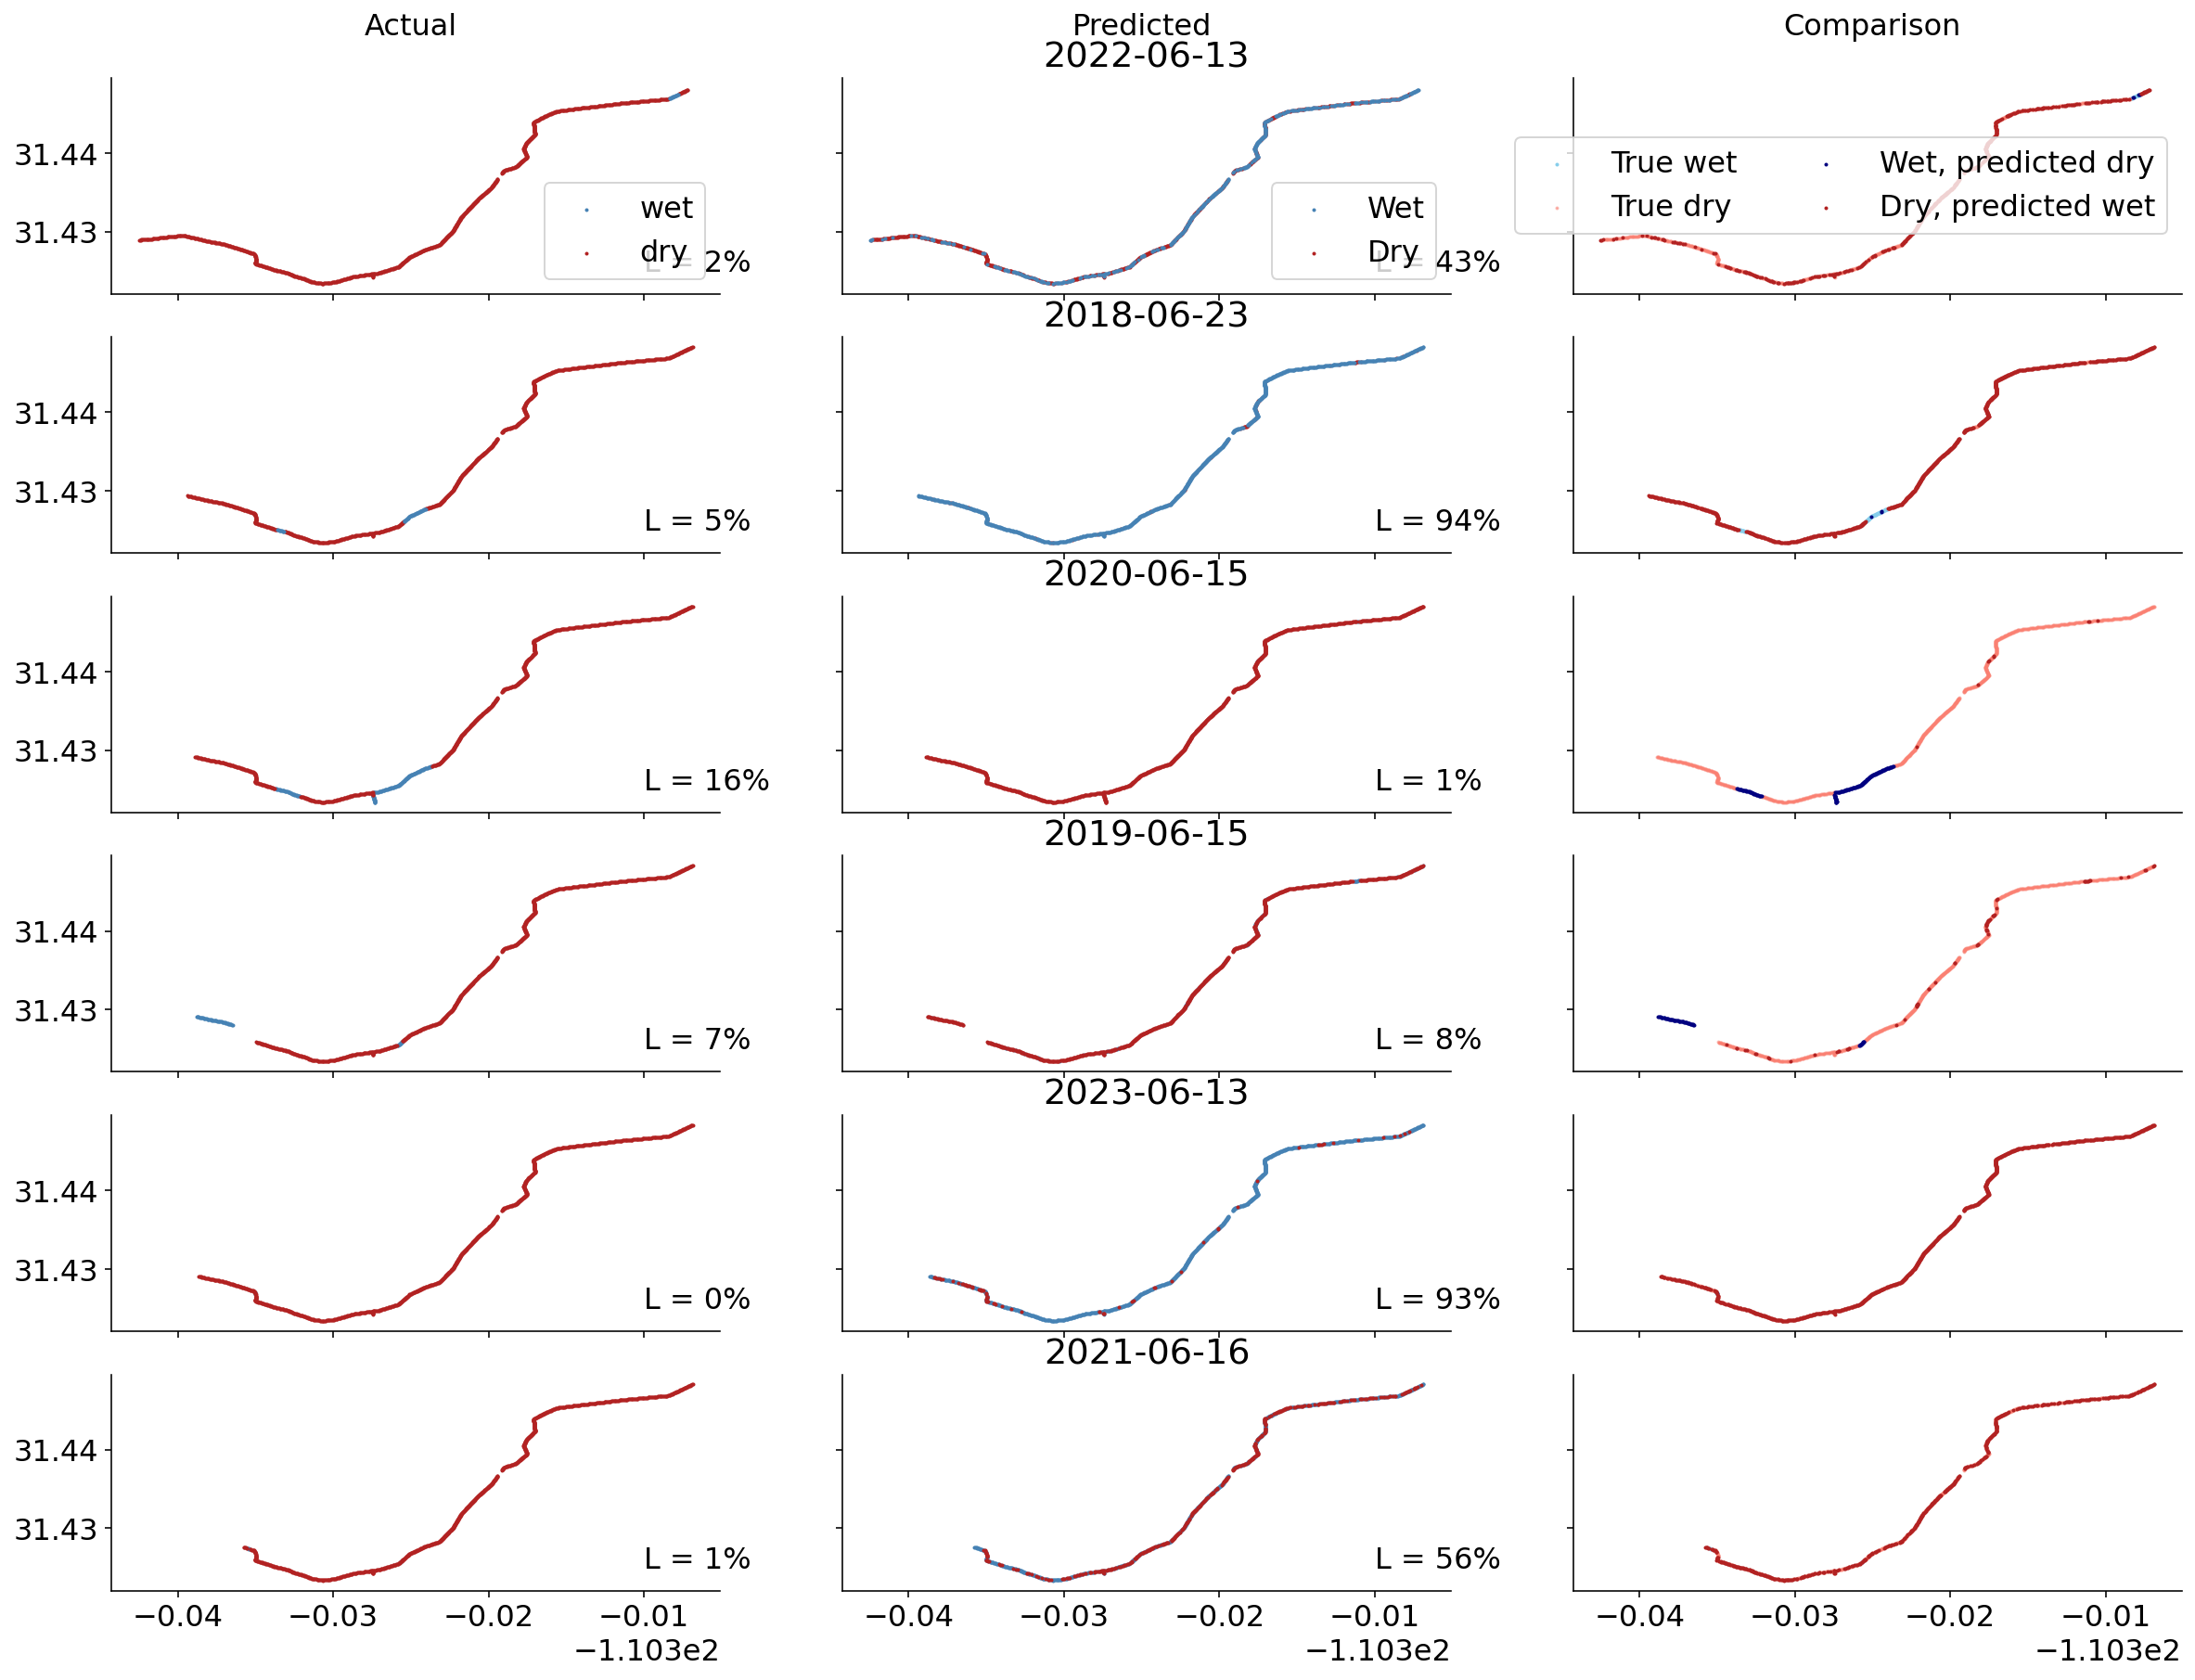

In [300]:
import matplotlib as mpl
import geopandas as gpd

size = 1

plt.rcParams.update({'font.size': 16})

fig,axs = plt.subplots(6,3,figsize = (20,15),
                       sharex=True,
                       sharey=True)
subset = df

xv,yv = -110.31,31.425

i=0
for date in df[df.assumption=='survey/imagery match'].date.unique():#subset.date.drop_duplicates().values[:4]:
  dfsub = subset[subset.date==date]
  if date=='2018-02-12':
    dfsub = dfsub[dfsub.area_updated<=20000]
  dfsub = dfsub.drop_duplicates()
  dfsub = gpd.GeoDataFrame(
    dfsub, geometry=gpd.points_from_xy(dfsub.x, dfsub.y), crs="EPSG:26912"
)
  dfsub = dfsub.to_crs('EPSG:4326')
  dfsub['x'] = dfsub.geometry.x
  dfsub['y'] = dfsub.geometry.y

  ax = axs[i,0]
  if i>1:
    zorder = -1
    zord1 = 100
  else:
    zorder = 100
    zord1 = -1
  dfsub2 = dfsub[(dfsub.wet==1)]
  pwet = len(dfsub2)/len(dfsub)*100
  ax.scatter(dfsub2.x,dfsub2.y,c='steelblue',
             s=size,label='wet',zorder=zorder)
  dfsub2 = dfsub[(dfsub.wet==0)]
  ax.scatter(dfsub2.x,dfsub2.y,c='firebrick',
             s=size,label='dry',zorder = zord1)
  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

    # ax.set_title('Actual')

  ax = axs[i,1]

  dfsub1 = dfsub[(dfsub.prediction==1)]
  pwet = len(dfsub1)/len(dfsub)*100
  ax.scatter(dfsub1.x,dfsub1.y,c='steelblue',
             s=size,label='Wet',
             zorder = zorder)
  dfsub1 = dfsub[(dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,c='firebrick',
             s=size,label='Dry',zorder = zord1)
  ax.set_title(str(date)[:10])
  if i==0:
    legend = ax.legend(loc='lower right')
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]

  ax.text(xv,yv,'L = '+str(round(pwet))+'%')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  ax = axs[i,2]

  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='skyblue',label='True wet',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='salmon',label='True dry',
             s=size, alpha=0.5)
  dfsub1 = dfsub[(dfsub.wet==1) &
                 (dfsub.prediction==0)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='navy',label='Wet, predicted dry',
             s=size)
  dfsub1 = dfsub[(dfsub.wet==0) &
                 (dfsub.prediction==1)]
  ax.scatter(dfsub1.x,dfsub1.y,
             c='firebrick',label='Dry, predicted wet',
             s=size)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  if i==0:
    legend = ax.legend(ncol=2)
    size1 = 50
#     legend.legendHandles[0]._sizes = [size1]
#     legend.legendHandles[1]._sizes = [size1]
#     legend.legendHandles[2]._sizes = [size1]
#     legend.legendHandles[3]._sizes = [size1]
  n = 70

  i+=1



axs[0,0].text(xv-.015,yv+.03,'Actual',
              ha = 'center',fontsize = 16)
axs[0,1].text(xv-.015,yv+.03,'Predicted',
              ha = 'center',fontsize = 16)
axs[0,2].text(xv-.015,yv+.03,'Comparison',
              ha = 'center',fontsize = 16)

# labels = ['a)','b)','c)',
#           'd)','e)','f)',
#           'g)','h)','i)',
#           'j)','k)','l)']

# k=0
# for i in range(4):
#   for j in range(3):
#     axs[i,j].text(-123.517,39.579,labels[k],
#                   fontsize = 16)
#     # print(i,j,k)
#     k+=1

# ax = axs[3,0]
# labels = [item.get_text() for item in ax.get_xticklabels()]
# for ax in [axs[3,0],axs[3,1],axs[3,2]]:
#   ax.set_xticklabels(labels,rotation=90)
#   ax.set_xlabel('Longitude')

# for ax in [axs[0,0],axs[1,0],axs[2,0]]:
#   ax.set_ylabel('Latitude')

# plt.savefig('training_maps.pdf',format='pdf',bbox_inches='tight')